In [1]:
#importing packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd #having some dificulty with geopandas, have tried a number of different versions,
#appears pyproj is the issue
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error

## Reading in Data

Data imported from Github repo, also available at the following source as provide by DrivenData on behalf of Taarifa (Tanzania Ministry of Water)

Data Source <https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/>

Data inlcudes a set of training data with labels and a set of test data for prediction and submission

Taking a look at the data below gives us a feel for what has been provided

In [2]:
values = pd.read_csv('Source_data/trainset_values.csv')

In [3]:
values.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...    never pay   
4  31.130847  -1.825359               Shuleni            0  ...    never pay   

  water_quality quality_group      quantity  quantity_group  \
0          soft          good        enough          enough   
1          soft          good  insufficient    insufficient   
2          soft          good        enough          enough   
3          soft          good           dry             dry   
4          soft          good      seasonal        seasonal   

                 source           source_type  source_class  \
0                spring                spring   groundwater   
1  rainwater harvesting  rainwater harvesting       surface   
2                   dam                   dam       surface   
3           machine dbh              borehole   groundwater   
4  rainwater harvesting  rainwater harvesting       surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe  

[5 rows x 40 columns]

In [4]:
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

We see that ther are some null values in columns 
['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']
that will need to be handled. It also appears that some columns provide overlapping information (extraction, management, payment, water quality and quantity, source and waterpoint). We will have to investiagte further if each column provides enough new information to keep. 

In [5]:
classes = pd.read_csv('Source_data/trainset_labels.csv')


Taking a look at the training labels below we see that there are 3 groups: functional, non functional and 

In [6]:
classes.head()

id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

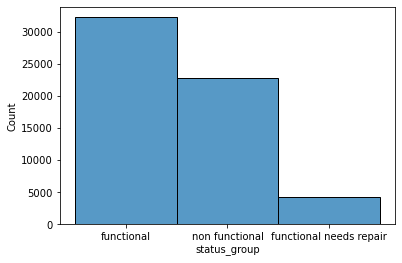

In [7]:
sns.histplot(data=classes, x='status_group')
plt.show()

In [8]:
values.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

We can add the labels onto the values dataframe in order to do some further EDA

In [9]:
values.insert(loc=1, column='class', value=classes['status_group'])

In [10]:
values.head()

id           class  amount_tsh date_recorded        funder  gps_height  \
0  69572      functional      6000.0    2011-03-14         Roman        1390   
1   8776      functional         0.0    2013-03-06       Grumeti        1399   
2  34310      functional        25.0    2013-02-25  Lottery Club         686   
3  67743  non functional         0.0    2013-01-28        Unicef         263   
4  19728      functional         0.0    2011-07-13   Action In A           0   

      installer  longitude   latitude              wpt_name  ...  \
0         Roman  34.938093  -9.856322                  none  ...   
1       GRUMETI  34.698766  -2.147466              Zahanati  ...   
2  World vision  37.460664  -3.821329           Kwa Mahundi  ...   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu  ...   
4       Artisan  31.130847  -1.825359               Shuleni  ...   

   payment_type water_quality quality_group      quantity  quantity_group  \
0      annually          soft          good        enough          enough   
1     never pay          soft          good  insufficient    insufficient   
2    per bucket          soft          good        enough          enough   
3     never pay          soft          good           dry             dry   
4     never pay          soft          good      seasonal        seasonal   

                 source           source_type source_class  \
0                spring                spring  groundwater   
1  rainwater harvesting  rainwater harvesting      surface   
2                   dam                   dam      surface   
3           machine dbh              borehole  groundwater   
4  rainwater harvesting  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe  

[5 rows x 41 columns]

In [11]:
data = values.copy()

There are a few columns that we don't expect to use as they tell use about the id of the wellpoints not the actual wellpoints. We will remove them.

In [12]:
data.drop(columns=['wpt_name', 'num_private', 'recorded_by'], inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   class                  59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

## Fill NaN values

We have some null values in the dataframe. Based upon the value being in categorical columns, witrh the exception of public meeting and permit, we will fill in the value 'unknown'. For permit and public meeting we will fill in False, making the assumption that the data not being recorded makes it less likely the additoinal administrative steps were taken.

In [14]:
data.fillna(inplace=True, value={'installer':'unknown','permit':False, 'funder':'unknown', 'public_meeting':False, 
                                 'scheme_management':'unknown', 'scheme_name':'unknown', 'subvillage':'unknown'})
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   class                  59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 59400 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              59400 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   basin                  59400 non-null  object 
 10  subvillage             59400 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

## Water and Equipment Information

### Source
Let's take a look at some details of the source columns ['source', 'source_type', 'source_class']

In [15]:
data['source'].value_counts(), data['source_type'].value_counts(), data['source_class'].value_counts()

(spring                  17021
 shallow well            16824
 machine dbh             11075
 river                    9612
 rainwater harvesting     2295
 hand dtw                  874
 lake                      765
 dam                       656
 other                     212
 unknown                    66
 Name: source, dtype: int64,
 spring                  17021
 shallow well            16824
 borehole                11949
 river/lake              10377
 rainwater harvesting     2295
 dam                       656
 other                     278
 Name: source_type, dtype: int64,
 groundwater    45794
 surface        13328
 unknown          278
 Name: source_class, dtype: int64)

'source' and 'source_type' have very little difference expect:
- 'river' and 'lake' categories combined to 'river/lake'
- 'other' and 'unknown' combined into a single category called 'other'
- 'machine dbw' and 'hand dtw' were combined into a single 'borehole' category

In [16]:
#Let's take a look at the distribution of the labels overall
labelcount = data.groupby('class')['id'].count()
labelcount = pd.concat([labelcount, data.groupby('class')['id'].apply(lambda x:'{0:.1f}%'.format(x.count()/len(data['id'])*100))], axis=1)
labelcount.columns = ['count', 'percent']
labelcount

count percent
class                                 
functional               32259   54.3%
functional needs repair   4317    7.3%
non functional           22824   38.4%

We can then compare this distrubtion against the distribution with each source type. If the value for the different sources are consistent with the average then it would mean we aren't necessary gather more data from having the most robust amount of columns. However, if there are differences then we would want to keep those differences intact for our model. We are looking to choose which of the source columns to use in order to limit colinearity in our data, though we could add this information back in at a later time if we think it could increase our model perfomance.

In [17]:
#Reviewing counts of labels per each source
sourcecount = data.groupby(['class', 'source'])['id'].count().unstack()
sourcecount

source                   dam  hand dtw  lake  machine dbh  other  \
class                                                              
functional               253       497   162         5422    126   
functional needs repair   24        17    12          491      1   
non functional           379       360   591         5162     85   

source                   rainwater harvesting  river  shallow well  spring  \
class                                                                        
functional                               1386   5465          8324   10592   
functional needs repair                   314   1221           957    1276   
non functional                            595   2926          7543    5153   

source                   unknown  
class                             
functional                    32  
functional needs repair        4  
non functional                30

In [18]:
#USing our counts to determine percentges for simpler comparison against the total percentages found above
sourceper = sourcecount/sourcecount.sum()*100
sourceper

source                         dam   hand dtw       lake  machine dbh  \
class                                                                   
functional               38.567073  56.864989  21.176471    48.957111   
functional needs repair   3.658537   1.945080   1.568627     4.433409   
non functional           57.774390  41.189931  77.254902    46.609481   

source                       other  rainwater harvesting      river  \
class                                                                 
functional               59.433962             60.392157  56.856013   
functional needs repair   0.471698             13.681917  12.702871   
non functional           40.094340             25.925926  30.441115   

source                   shallow well     spring    unknown  
class                                                        
functional                  49.476938  62.229011  48.484848  
functional needs repair      5.688302   7.496622   6.060606  
non functional              44.834760  30.274367  45.454545

As we will be doing multiple comparisons between the categorical label values and the other categorical columns, lets create a new fuction that create a clean and informational visual.

In [19]:
def Chi_sq_test(df, dependant, independant):
    #takes in the names of a dependant and independant variable (column), runs a chi squared test and then outputs 
    #a seaborn heatmap of the percent difference between the expected and actual values
    
    #create cotingency table
    count_table = df.groupby([dependant, independant])['id'].count().unstack()
    count_table.fillna(0, inplace=True)
    count_table = count_table.astype('int')
    
    #Chi Squared test is for only counts above 5, we are keeping the same ratio, but increasing min value to 5 in each column
    if count_table.isin(range(0,5)).any().any():
        for j in range(len(count_table.columns)):
            for i in range(len(count_table.index)):
                if count_table.iloc[i,j] < 1:
                    count_table.iloc[i,j] = 5
                    count_table.iloc[:,j] = count_table.iloc[:,j]*5
                elif count_table.iloc[i,j] <5:
                    count_table.iloc[:,j] = count_table.iloc[:,j]*(5/count_table.iloc[i,j])
    
    stat, p, dof, expected = chi2_contingency(count_table)
    
    #print test information
    print('P-Value = {}'.format(p))
    print('Chi Statistic = {}'.format(stat))
    print('Degrees of Freedom = {}'.format(dof))
    
    #caluclate and print heatmap
    plt.figure(figsize=(12,6))
    sns.heatmap(((count_table - expected) / count_table *100), annot=True, vmax=100, vmin=-100, fmt='.1f', 
                annot_kws={'rotation': 90}, cmap='viridis')
    plt.title('Percent Difference of Expected vs. Actual Classes per {}'.format(str.title(independant)))
    plt.show()
    #Print count table that Chi Sq Test is derived from, uncomment if desired
    #print(count_table)

P-Value = 0.0
Chi Statistic = 2691.9231644048
Degrees of Freedom = 18


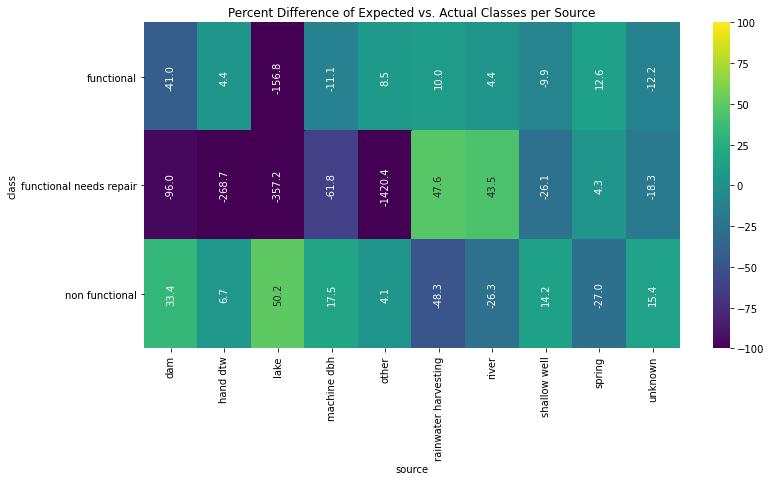

In [20]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'source')

The overall data had values of:
- functional 54.3%
- functional needs repair 7.3% 
- non functional 38.4%

Source categories hand dtw, other, river, shallow well, unknown

Source categories dam, lake, machine dbh, rainwater harvesting, and spring deviate from the overall numbers in varying ways. For example, dam had nearly a reversal of the percentages for functional and non functional making it a strong feature for recognizing non functional well points. Also while rainwater harvesting has a slightly higher to overall percent functional, it also has double the functional needs repair of the overall and will be a good indicator for the that category. We will keep the 'source' column and drop 'source_type' and 'source_class'.

In [21]:
data = data.drop(columns=['source_type', 'source_class'])
data.columns

Index(['id', 'class', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

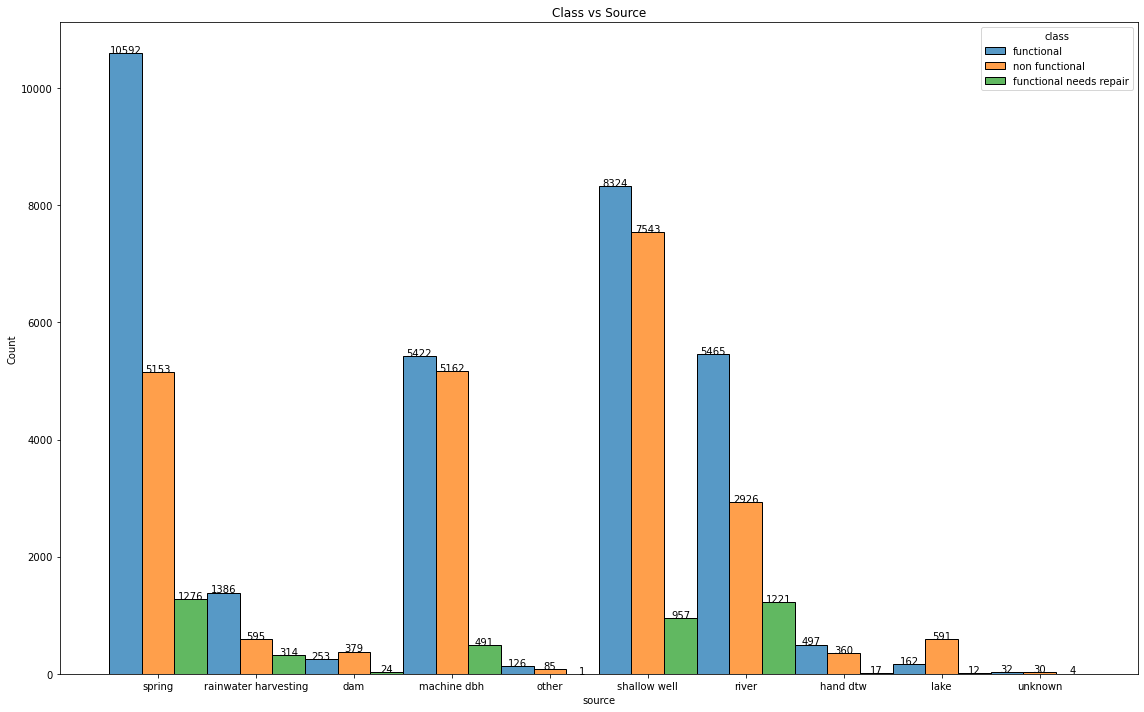

In [22]:
#plotting source and label comparisons
plt.figure(figsize=(16, 10))
ax=sns.histplot(data=values, x='source', hue='class', multiple='dodge')
total = len(values['class'])
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2), y=height+0., s=height, ha='center')
plt.title('Class vs Source')
plt.tight_layout()
plt.show()

We will look at the other features that have multiple columns. For now we are looking to keep only one of each column to limit collinearity, though we can come back later if we feel they have value to add. 

### Extraction methods
We can continue our review of the data by looking through the columns detailing the extraction methods used

In [23]:
data['extraction_type'].value_counts(), data['extraction_type_group'].value_counts(), data['extraction_type_class'].value_counts()

(gravity                      26780
 nira/tanira                   8154
 other                         6430
 submersible                   4764
 swn 80                        3670
 mono                          2865
 india mark ii                 2400
 afridev                       1770
 ksb                           1415
 other - rope pump              451
 other - swn 81                 229
 windmill                       117
 india mark iii                  98
 cemo                            90
 other - play pump               85
 walimi                          48
 climax                          32
 other - mkulima/shinyanga        2
 Name: extraction_type, dtype: int64,
 gravity            26780
 nira/tanira         8154
 other               6430
 submersible         6179
 swn 80              3670
 mono                2865
 india mark ii       2400
 afridev             1770
 rope pump            451
 other handpump       364
 other motorpump      122
 wind-powered         117
 i

P-Value = 0.0
Chi Statistic = 7582.230959972138
Degrees of Freedom = 34


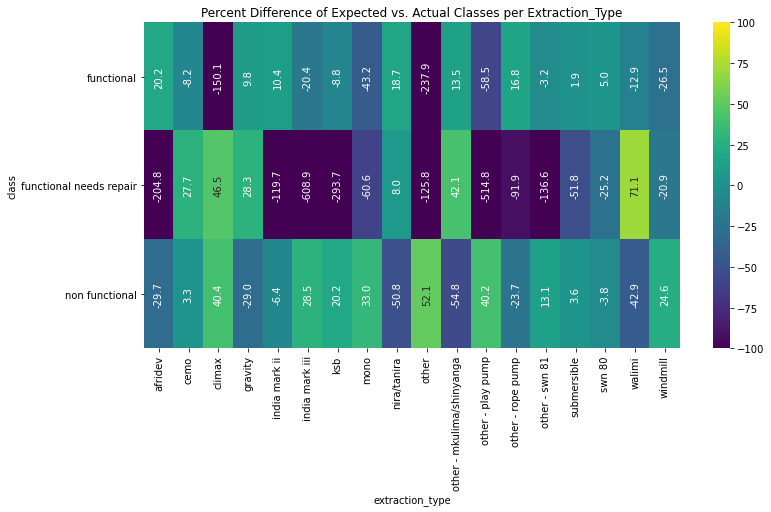

In [24]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'extraction_type')

The overall data had values of:
- functional 54.3%
- functional needs repair 7.3% 
- non functional 38.4%

Most categories seem to deviate from the norm so we want to keep ans many as possible, however some have relatively small data asscoaited with them, i.e. other-mkulima/shinyanga. For that reason we are going to use the intermediate break down with the exception of keeping ksb and submersible seperate as well as cemo and climax seperate. These categories that are merged under the extraction_type_group column seem to have enough value to keep seperate. We will keep the extraction_type column, but map other swn 81, other-play pump, walimi and other-mkulima/shinyanga together into a single other-handpump group

In [25]:
data = data.drop(columns=['extraction_type_group', 'extraction_type_class'])
data['extraction_type'].replace({'other - swn 81':'other-handpump',
                                 'other - play pump':'other-handpump', 
                                 'walimi':'other-handpump', 
                                 'other - mkulima/shinyanga':'other-handpump',
                                'swn 80':'swn_80',
                                 'nira/tanira':'nira-tanira',
                                'india mark ii':'india_mark_ii',
                                'india mark iii':'india_mark_iii',
                                'other - rope pump':'other-rope_pump',}, inplace=True)
data['extraction_type'].unique()

array(['gravity', 'submersible', 'swn_80', 'nira-tanira', 'india_mark_ii',
       'other', 'ksb', 'mono', 'windmill', 'afridev', 'other-rope_pump',
       'india_mark_iii', 'other-handpump', 'cemo', 'climax'], dtype=object)

P-Value = 0.0
Chi Statistic = 7421.308089973847
Degrees of Freedom = 28


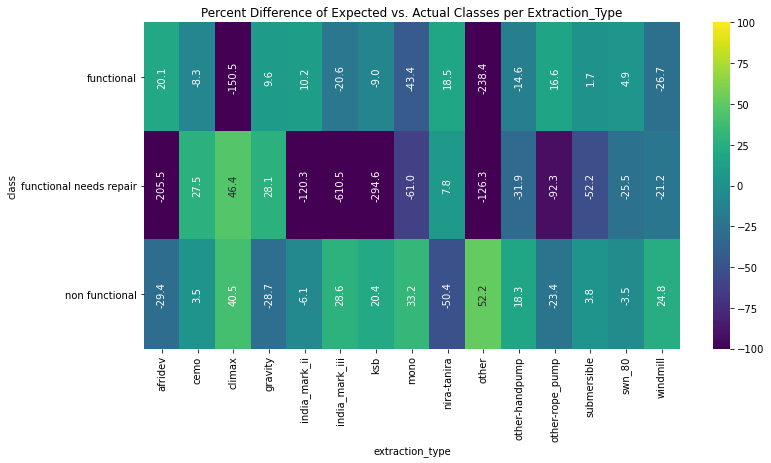

In [26]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'extraction_type')

We should also clean up some of the source names before we go further to eliminate erroneous spaces and symbols.

In [27]:
data['source'].replace({'shallow well':'shallow_well',
                       'machine dbh':'machine_dbh',
                       'rainwater harvesting':'rainwater_harvesting',
                       'hand dtw':'hand_dtw'}, inplace=True)
data['source'].unique()

array(['spring', 'rainwater_harvesting', 'dam', 'machine_dbh', 'other',
       'shallow_well', 'river', 'hand_dtw', 'lake', 'unknown'],
      dtype=object)

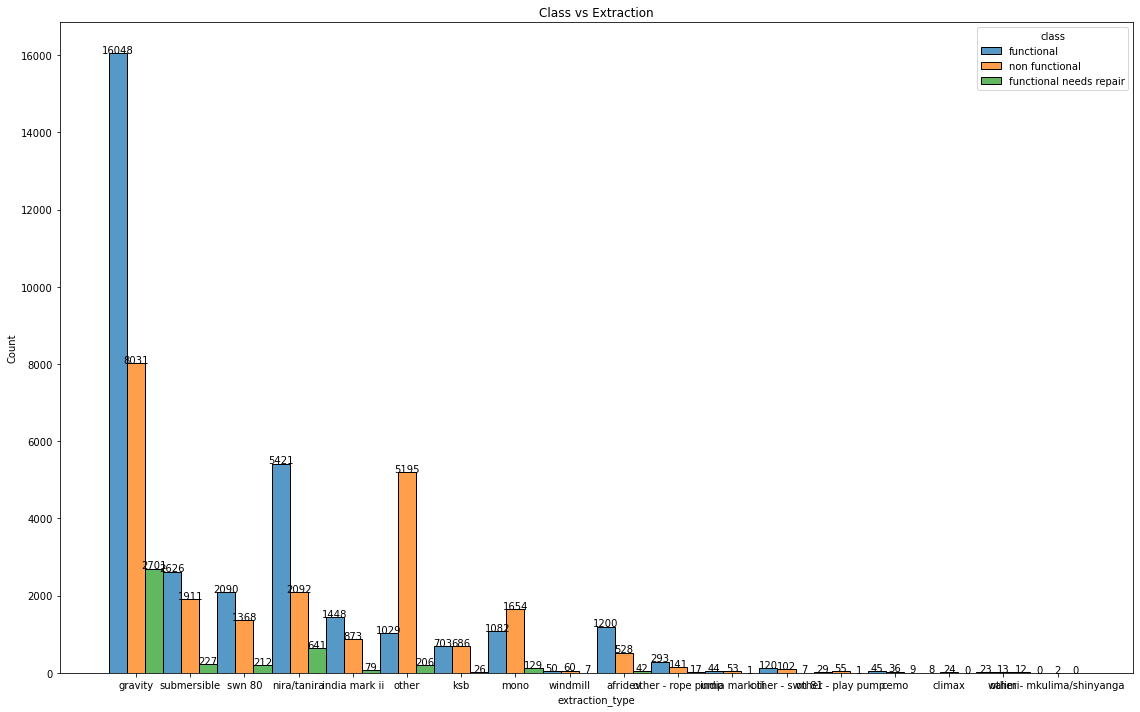

In [28]:
#plotting extraction_type and label comparisons
plt.figure(figsize=(16, 10))
ax=sns.histplot(data=values, x='extraction_type', hue='class', multiple='dodge')
total = len(values['class'])
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2), y=height+0., s=height, ha='center')
plt.title('Class vs Extraction')
plt.tight_layout()
plt.show()

### Water Quality and Quantity
Let's take a look at quality, quantity and waterpoint type. As with the previous source and extraction columns we are looking to limit collinearity without giving away data that is useful for prediction

In [29]:
data['water_quality'].value_counts(), data['quality_group'].value_counts()

(soft                  50818
 salty                  4856
 unknown                1876
 milky                   804
 coloured                490
 salty abandoned         339
 fluoride                200
 fluoride abandoned       17
 Name: water_quality, dtype: int64,
 good        50818
 salty        5195
 unknown      1876
 milky         804
 colored       490
 fluoride      217
 Name: quality_group, dtype: int64)

In [30]:
data['quantity'].value_counts(), data['quantity_group'].value_counts()

(enough          33186
 insufficient    15129
 dry              6246
 seasonal         4050
 unknown           789
 Name: quantity, dtype: int64,
 enough          33186
 insufficient    15129
 dry              6246
 seasonal         4050
 unknown           789
 Name: quantity_group, dtype: int64)

For quality, it would seem the only change from water quality to quality group is combining salty columns, fluoride columns and renaming soft to good. We will drop the quality group column. 

For quantity, there is diference between the columns so we will drop the quantity group column

In [31]:
data.drop(columns=['quality_group', 'quantity_group'], inplace=True)

P-Value = 0.0
Chi Statistic = 2325.4900379674204
Degrees of Freedom = 14


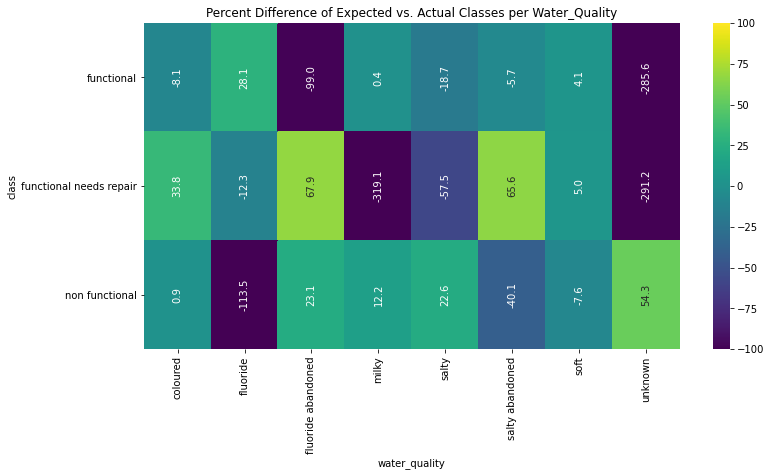

In [32]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'water_quality')

In [33]:
data['water_quality_rank'] = data['water_quality'].map({'fluoride':7, 'soft':6, 'coloured':5,'milky':4, 
                                                        'salty':3, 'salty abandoned':2, 'fluoride abandoned':1, 
                                                       'unknown':0})

P-Value = 0.0
Chi Statistic = 11360.76789585276
Degrees of Freedom = 8


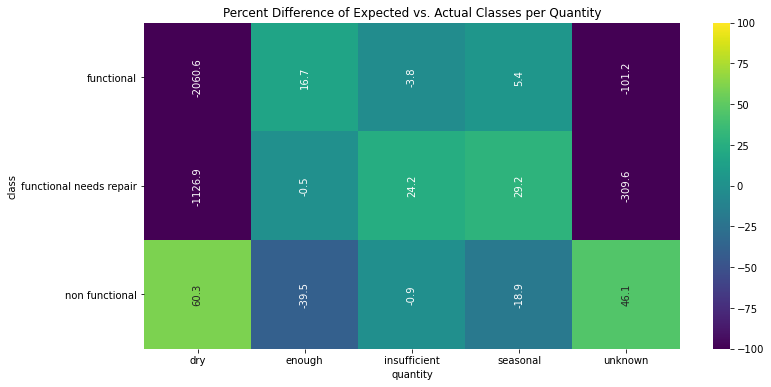

In [34]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'quantity')

In [35]:
data['quantity_rank'] = data['quantity'].map({'enough':4, 'seasonal':3, 'insufficient':2,'unknown':1, 
                                                        'dry':0})

In [36]:
data['quant_qual_rank']=data['quantity_rank']+data['water_quality_rank']

### Waterpoint Type

In [37]:
data['waterpoint_type'].value_counts(), data['waterpoint_type_group'].value_counts()

(communal standpipe             28522
 hand pump                      17488
 other                           6380
 communal standpipe multiple     6103
 improved spring                  784
 cattle trough                    116
 dam                                7
 Name: waterpoint_type, dtype: int64,
 communal standpipe    34625
 hand pump             17488
 other                  6380
 improved spring         784
 cattle trough           116
 dam                       7
 Name: waterpoint_type_group, dtype: int64)

The only difference being the combination of communal standpipe columns in waterpoint type group. We will drop the waterpoint type group.

In [38]:
data.drop(columns=['waterpoint_type_group'],inplace=True)

P-Value = 0.0
Chi Statistic = 7588.339344078205
Degrees of Freedom = 12


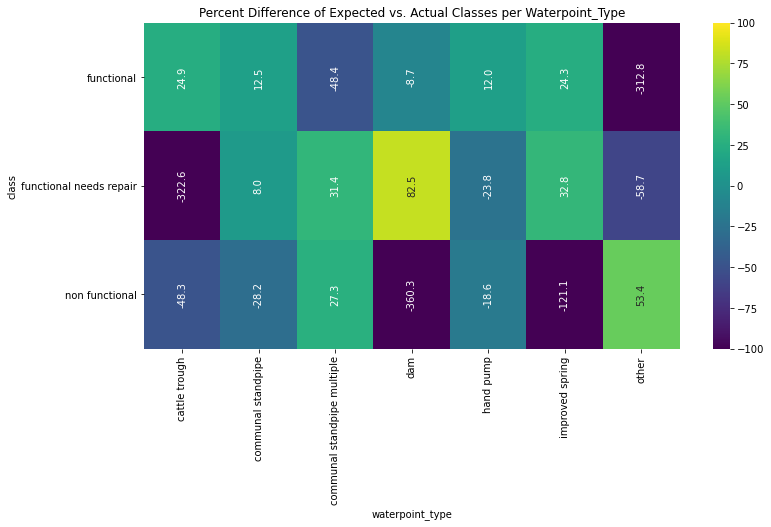

In [39]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'waterpoint_type')

Let's look into the management data. It is likely we will follow the same logic as with the subvillages where we keep the larger groups and part the smaller ones into bins.

## Location Information
Now lets take a look at some of the location columns

### Latitude / Longitude
Let's take a look at the latitude and longitude columns. It is possible we will see this ditribution line up well with population as we expect more wellpoints in populated areas, though we aren't sure what the calss trend for these areas is yet.

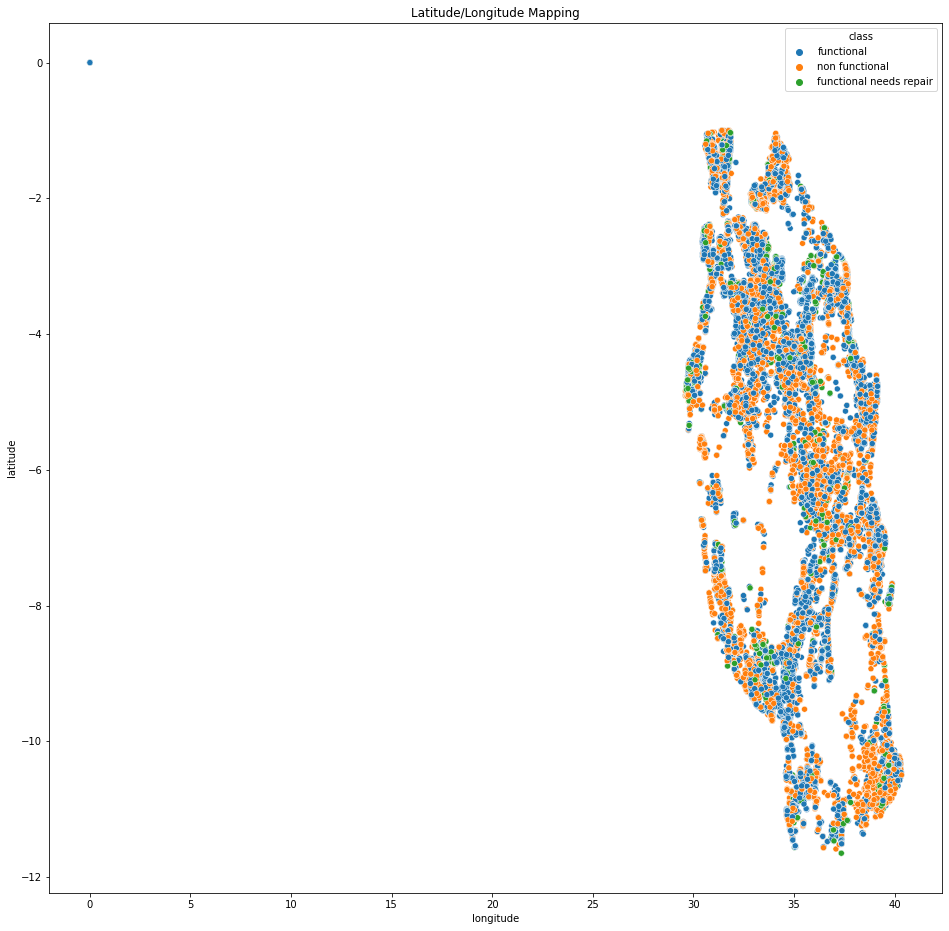

In [40]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data, y='latitude', x='longitude', hue='class')
plt.title('Latitude/Longitude Mapping')
plt.show()

There is a few datapoints that seem to have incorrect values, lets take a look.

In [41]:
data['longitude'].describe()

count    59400.000000
mean        34.077427
std          6.567432
min          0.000000
25%         33.090347
50%         34.908743
75%         37.178387
max         40.345193
Name: longitude, dtype: float64

In [42]:
data.loc[data['longitude']==0]

id                    class  amount_tsh date_recorded  \
21      6091               functional         0.0    2013-02-10   
53     32376           non functional         0.0    2011-08-01   
168    72678               functional         0.0    2013-01-30   
177    56725           non functional         0.0    2013-01-17   
253    13042  functional needs repair         0.0    2012-10-29   
...      ...                      ...         ...           ...   
59189  62177  functional needs repair         0.0    2011-07-18   
59208   3631               functional         0.0    2013-01-22   
59295  60843  functional needs repair         0.0    2011-07-19   
59324    748               functional         0.0    2013-01-22   
59374  49651               functional         0.0    2012-10-29   

                       funder  gps_height     installer  longitude  \
21                       Dwsp           0           DWE        0.0   
53     Government Of Tanzania           0    Government        0.0   
168                       Wvt           0           WVT        0.0   
177               Netherlands           0           DWE        0.0   
253                    Hesawa           0           DWE        0.0   
...                       ...         ...           ...        ...   
59189                    Dwsp           0           DWE        0.0   
59208                    Dwsp           0           DWE        0.0   
59295                   Rwssp           0           DWE        0.0   
59324            World Vision           0  World Vision        0.0   
59374                   Rwssp           0           DWE        0.0   

           latitude          basin  ... management_group    payment  \
21    -2.000000e-08  Lake Victoria  ...       user-group    unknown   
53    -2.000000e-08  Lake Victoria  ...       user-group    unknown   
168   -2.000000e-08  Lake Victoria  ...       parastatal      other   
177   -2.000000e-08  Lake Victoria  ...       user-group    unknown   
253   -2.000000e-08  Lake Victoria  ...       user-group  never pay   
...             ...            ...  ...              ...        ...   
59189 -2.000000e-08  Lake Victoria  ...       user-group      other   
59208 -2.000000e-08  Lake Victoria  ...       user-group    unknown   
59295 -2.000000e-08  Lake Victoria  ...       user-group  never pay   
59324 -2.000000e-08  Lake Victoria  ...       user-group    unknown   
59374 -2.000000e-08  Lake Victoria  ...       user-group      other   

       payment_type  water_quality      quantity                source  \
21          unknown        unknown       unknown          shallow_well   
53          unknown        unknown           dry           machine_dbh   
168           other           soft      seasonal  rainwater_harvesting   
177         unknown           soft        enough          shallow_well   
253       never pay           soft  insufficient          shallow_well   
...             ...            ...           ...                   ...   
59189         other           soft        enough          shallow_well   
59208       unknown           soft        enough          shallow_well   
59295     never pay           soft        enough          shallow_well   
59324       unknown           soft        enough          shallow_well   
59374         other           soft        enough          shallow_well   

                   waterpoint_type  water_quality_rank quantity_rank  \
21                       hand pump                   0             1   
53     communal standpipe multiple                   0             0   
168             communal standpipe                   6             3   
177                          other                   6             4   
253                      hand pump                   6             2   
...                            ...                 ...           ...   
59189                    hand pump                   6             4   
59208                    hand pump            

The points all have the Lake Victoria basin. We will use an random value between the 25th and 75th percentiles from all datapoints in the Lake Victoria basin to fill in the zero values.

In [43]:
data.loc[data['basin']=='Lake Victoria']['longitude'].describe()

count    10248.000000
mean        27.284607
std         12.278315
min          0.000000
25%         30.864549
50%         32.686490
75%         33.584817
max         35.511809
Name: longitude, dtype: float64

In [44]:
data.loc[data['longitude'] == 0, 'longitude'] = np.random.choice(range(31,33), 1812)

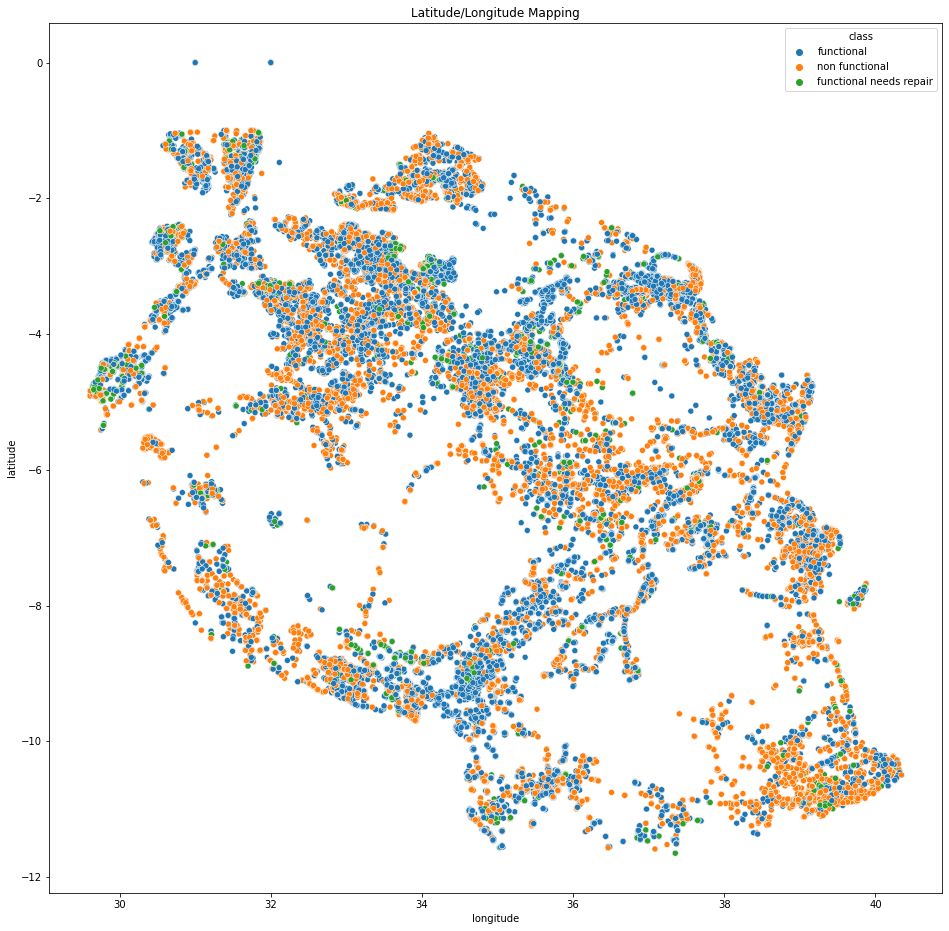

In [45]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data, y='latitude', x='longitude', hue='class')
plt.title('Latitude/Longitude Mapping')
plt.show()

There is still an issue with a latitude value being zero, lets take a look

In [46]:
#Finding all columns with latitude == 0
data.loc[data['latitude']==0]

Empty DataFrame
Columns: [id, class, amount_tsh, date_recorded, funder, gps_height, installer, longitude, latitude, basin, subvillage, region, region_code, district_code, lga, ward, population, public_meeting, scheme_management, scheme_name, permit, construction_year, extraction_type, management, management_group, payment, payment_type, water_quality, quantity, source, waterpoint_type, water_quality_rank, quantity_rank, quant_qual_rank]
Index: []

[0 rows x 34 columns]

In [47]:
#widening the search
data.loc[data['latitude']>-1]

id                    class  amount_tsh date_recorded  \
21      6091               functional         0.0    2013-02-10   
53     32376           non functional         0.0    2011-08-01   
168    72678               functional         0.0    2013-01-30   
177    56725           non functional         0.0    2013-01-17   
253    13042  functional needs repair         0.0    2012-10-29   
...      ...                      ...         ...           ...   
59189  62177  functional needs repair         0.0    2011-07-18   
59208   3631               functional         0.0    2013-01-22   
59295  60843  functional needs repair         0.0    2011-07-19   
59324    748               functional         0.0    2013-01-22   
59374  49651               functional         0.0    2012-10-29   

                       funder  gps_height     installer  longitude  \
21                       Dwsp           0           DWE       32.0   
53     Government Of Tanzania           0    Government       31.0   
168                       Wvt           0           WVT       31.0   
177               Netherlands           0           DWE       31.0   
253                    Hesawa           0           DWE       31.0   
...                       ...         ...           ...        ...   
59189                    Dwsp           0           DWE       32.0   
59208                    Dwsp           0           DWE       32.0   
59295                   Rwssp           0           DWE       31.0   
59324            World Vision           0  World Vision       31.0   
59374                   Rwssp           0           DWE       32.0   

           latitude          basin  ... management_group    payment  \
21    -2.000000e-08  Lake Victoria  ...       user-group    unknown   
53    -2.000000e-08  Lake Victoria  ...       user-group    unknown   
168   -2.000000e-08  Lake Victoria  ...       parastatal      other   
177   -2.000000e-08  Lake Victoria  ...       user-group    unknown   
253   -2.000000e-08  Lake Victoria  ...       user-group  never pay   
...             ...            ...  ...              ...        ...   
59189 -2.000000e-08  Lake Victoria  ...       user-group      other   
59208 -2.000000e-08  Lake Victoria  ...       user-group    unknown   
59295 -2.000000e-08  Lake Victoria  ...       user-group  never pay   
59324 -2.000000e-08  Lake Victoria  ...       user-group    unknown   
59374 -2.000000e-08  Lake Victoria  ...       user-group      other   

       payment_type  water_quality      quantity                source  \
21          unknown        unknown       unknown          shallow_well   
53          unknown        unknown           dry           machine_dbh   
168           other           soft      seasonal  rainwater_harvesting   
177         unknown           soft        enough          shallow_well   
253       never pay           soft  insufficient          shallow_well   
...             ...            ...           ...                   ...   
59189         other           soft        enough          shallow_well   
59208       unknown           soft        enough          shallow_well   
59295     never pay           soft        enough          shallow_well   
59324       unknown           soft        enough          shallow_well   
59374         other           soft        enough          shallow_well   

                   waterpoint_type  water_quality_rank quantity_rank  \
21                       hand pump                   0             1   
53     communal standpipe multiple                   0             0   
168             communal standpipe                   6             3   
177                          other                   6             4   
253                      hand pump                   6             2   
...                            ...                 ...           ...   
59189                    hand pump                   6             4   
59208                    hand pump            

In [48]:
#we can further tighen the search now that we see some of the issue values as -2.0E-08
data.loc[data['latitude']>-.01]

id                    class  amount_tsh date_recorded  \
21      6091               functional         0.0    2013-02-10   
53     32376           non functional         0.0    2011-08-01   
168    72678               functional         0.0    2013-01-30   
177    56725           non functional         0.0    2013-01-17   
253    13042  functional needs repair         0.0    2012-10-29   
...      ...                      ...         ...           ...   
59189  62177  functional needs repair         0.0    2011-07-18   
59208   3631               functional         0.0    2013-01-22   
59295  60843  functional needs repair         0.0    2011-07-19   
59324    748               functional         0.0    2013-01-22   
59374  49651               functional         0.0    2012-10-29   

                       funder  gps_height     installer  longitude  \
21                       Dwsp           0           DWE       32.0   
53     Government Of Tanzania           0    Government       31.0   
168                       Wvt           0           WVT       31.0   
177               Netherlands           0           DWE       31.0   
253                    Hesawa           0           DWE       31.0   
...                       ...         ...           ...        ...   
59189                    Dwsp           0           DWE       32.0   
59208                    Dwsp           0           DWE       32.0   
59295                   Rwssp           0           DWE       31.0   
59324            World Vision           0  World Vision       31.0   
59374                   Rwssp           0           DWE       32.0   

           latitude          basin  ... management_group    payment  \
21    -2.000000e-08  Lake Victoria  ...       user-group    unknown   
53    -2.000000e-08  Lake Victoria  ...       user-group    unknown   
168   -2.000000e-08  Lake Victoria  ...       parastatal      other   
177   -2.000000e-08  Lake Victoria  ...       user-group    unknown   
253   -2.000000e-08  Lake Victoria  ...       user-group  never pay   
...             ...            ...  ...              ...        ...   
59189 -2.000000e-08  Lake Victoria  ...       user-group      other   
59208 -2.000000e-08  Lake Victoria  ...       user-group    unknown   
59295 -2.000000e-08  Lake Victoria  ...       user-group  never pay   
59324 -2.000000e-08  Lake Victoria  ...       user-group    unknown   
59374 -2.000000e-08  Lake Victoria  ...       user-group      other   

       payment_type  water_quality      quantity                source  \
21          unknown        unknown       unknown          shallow_well   
53          unknown        unknown           dry           machine_dbh   
168           other           soft      seasonal  rainwater_harvesting   
177         unknown           soft        enough          shallow_well   
253       never pay           soft  insufficient          shallow_well   
...             ...            ...           ...                   ...   
59189         other           soft        enough          shallow_well   
59208       unknown           soft        enough          shallow_well   
59295     never pay           soft        enough          shallow_well   
59324       unknown           soft        enough          shallow_well   
59374         other           soft        enough          shallow_well   

                   waterpoint_type  water_quality_rank quantity_rank  \
21                       hand pump                   0             1   
53     communal standpipe multiple                   0             0   
168             communal standpipe                   6             3   
177                          other                   6             4   
253                      hand pump                   6             2   
...                            ...                 ...           ...   
59189                    hand pump                   6             4   
59208                    hand pump            

Let's fill these values in a similar manner to the longitiude values using a random value between the 25th and 75th percentile of Lake Victoria basin datapoints.

In [49]:
data.loc[data['basin']=='Lake Victoria']['latitude'].describe()

count    1.024800e+04
mean    -1.866879e+00
std      1.047662e+00
min     -3.933140e+00
25%     -2.689709e+00
50%     -1.911210e+00
75%     -1.343601e+00
max     -2.000000e-08
Name: latitude, dtype: float64

In [50]:
data.loc[data['latitude']>-0.01, 'latitude'] = -1*np.random.choice(range(1,2))

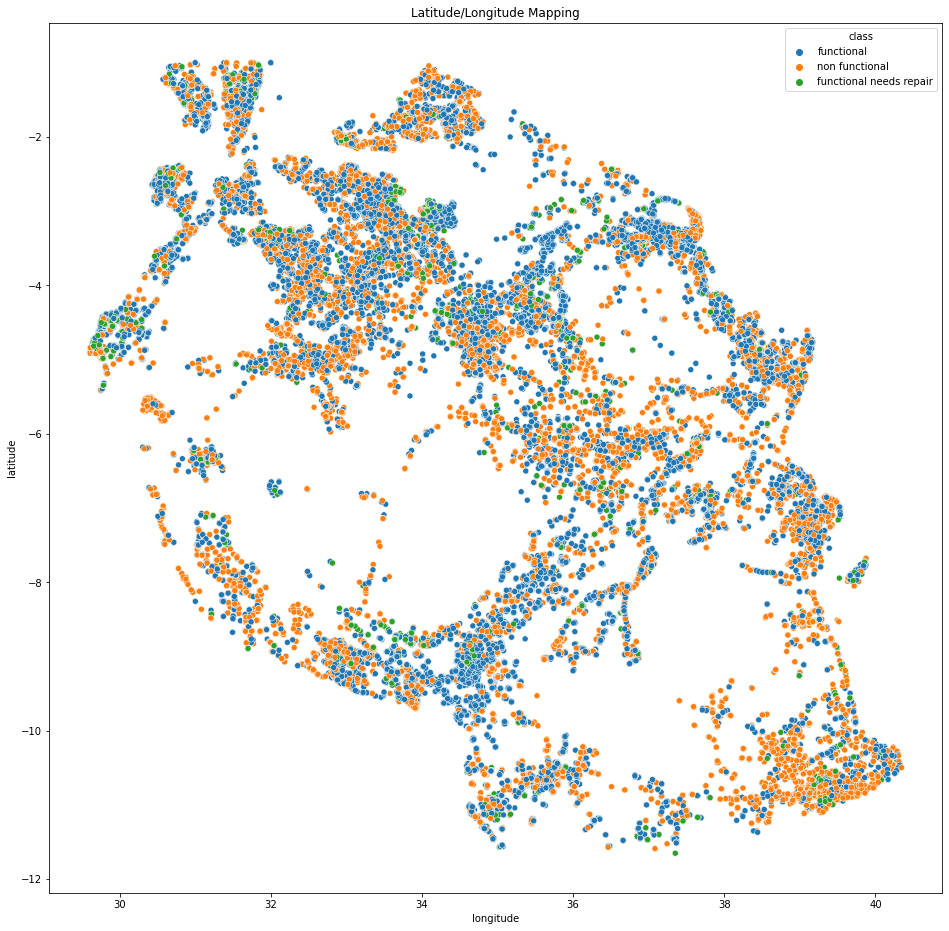

In [51]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data, y='latitude', x='longitude', hue='class')
plt.title('Latitude/Longitude Mapping')
plt.show()

### Subvillage

There are over 19k subvillages. It would be better to take the more common villages and group the less common villages into an 'other' categories. 

In [52]:
data['subvillage'].value_counts().tail(40)

Nyang'Anga              1
Bane                    1
Kibiti                  1
Mwafa                   1
Maforoni Vumilila       1
Chamjumbe               1
Kimamba Water Supply    1
Mihehe                  1
Unyonge                 1
Kwajemano               1
Kibwendeisiza           1
Sabrata                 1
Kinaki                  1
Unango Office           1
Likoto                  1
Vianzi B                1
Reginamundi             1
Dirawa                  1
Kokakwe                 1
Bandagi                 1
Nanyanje Juu            1
Magagura B              1
Busulwanguku            1
Yoliamwama              1
Gallapo Mission         1
Makelele                1
Kwadungu                1
Jojiro                  1
Takalagane              1
Makurugusi Center       1
Shibingo                1
Kijima                  1
Kitae                   1
Mlandizi Juu            1
Foroforo                1
Mwamigagani             1
Mwabadimu               1
Kitagula                1
Dimba       

There are a number of subvillages that are not names. We will need to find them and correct them.

In [53]:
svshort = data.loc[data['subvillage'].str.len() <=3]
svshort['subvillage'].unique()

array(['J', 'I', 'Ccm', 'Juu', 'M', 'S', 'K', 'Rc', 'L', '1', 'Ccb',
       'Nmc', 'Sia', '19', 'U', 'Uri', 'T', '54', 'Trm', 'Mug', 'Kiv',
       'N', '45', 'Tia', 'Kia', 'Hoi', 'No4', 'Igo', 'Imi', 'Kw', 'Cct',
       'C', '63', 'F', 'Ddc', 'Mch', '18', 'Raa', 'Moa', 'Cca', 'A', 'K9',
       '62', '60', 'Uwa', 'Iwe', '49', 'Mcu', 'Kiu', '43', 'Nbc', 'Sau',
       'G', 'Saa', 'Jj', '23B', 'Nhc', '22B', 'Rtc', 'Uti', 'Toa', 'Tii',
       'W', 'Mwa', 'Uwt', 'Oro', 'Asd', '20', 'Oru', 'P', 'Bbc', 'R',
       'Rau', 'Ita', '42', 'Tfa', 'O', '48', 'Q', 'Kwa', 'W/S', 'Nai',
       'Rt', 'Sie', 'Hhh', 'Vuo', 'Mw', 'Dmp', '47', '44', 'Goo', '##',
       'Tai', '30', '24', 'Tdd', '61B', 'B', '24B', 'Gh', 'Sua', 'Bea',
       'Dum', 'Mue', 'Hu'], dtype=object)

In [54]:
svshort['subvillage'].nunique(), data['subvillage'].nunique()

(105, 19288)

Based on the amount of subvillages that don't have proper names and the amount of categories, we are going to impute correct values for the low character subvillages using KNN and the latitude and longitudes. We can then group all of the subvillages with less than 90 wellpoints into a single category of other. This allows any predictive power form the areas with more wells, which we would think are more populous and possibly more used/serviced, to remain without creating noise.

In [55]:
#Correct subvillage names with 3 or less characters based on KNeigborsRegressor and latitiude/longitude
sv_trainX = data.loc[data['subvillage'].str.len()>3, ['latitude', 'longitude']]
sv_trainy = data.loc[data['subvillage'].str.len()>3, ['subvillage']]
knn_sv = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='euclidean')
knn_sv.fit(sv_trainX, sv_trainy)
data.loc[data['subvillage'].str.len()<=3, ['subvillage']] = knn_sv.predict(data.loc[data['subvillage'].str.len()<=3, 
                                                                           ['latitude', 'longitude']])  

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


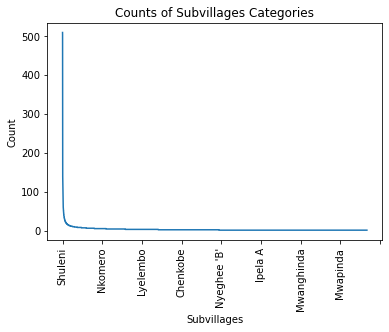

In [56]:
data['subvillage'].value_counts().plot()
plt.title('Counts of Subvillages Categories')
plt.xlabel('Subvillages')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [57]:
counts = data['subvillage'].value_counts()
verybig = counts.loc[counts.between(400,515)].index
big = counts.loc[counts.between(100,400)].index
medium = counts.loc[counts.between(50,100)].index
small = counts.loc[counts.between(25,50)].index
verysmall = counts.loc[counts.between(15,25)].index
smaller = counts.loc[counts.between(5,15)].index
smallest = counts.loc[counts.between(1,5)].index
single = counts.loc[counts ==1].index
data.loc[data['subvillage'].isin(verybig), 'subvillage_rank'] = 7
data.loc[data['subvillage'].isin(big), 'subvillage_rank'] = 6
data.loc[data['subvillage'].isin(medium), 'subvillage_rank'] = 5
data.loc[data['subvillage'].isin(small), 'subvillage_rank'] = 4
data.loc[data['subvillage'].isin(verysmall), 'subvillage_rank'] = 3
data.loc[data['subvillage'].isin(smaller), 'subvillage_rank'] = 2
data.loc[data['subvillage'].isin(smallest), 'subvillage_rank'] = 1
data.loc[data['subvillage'].isin(single), 'subvillage_rank'] = 0

In [58]:
data['subvillage_rank'] = data['subvillage_rank'].astype('int')

In [59]:
data['subvillage_rank'].value_counts()

1    22484
2    13891
0     9323
3     3172
4     3090
5     2994
6     2926
7     1520
Name: subvillage_rank, dtype: int64

In [60]:
counts = data['subvillage'].value_counts()
counts = counts.loc[counts >=90]
counts = list(counts.index)
data.loc[~data['subvillage'].isin(counts), 'subvillage'] = 'other'

In [61]:
data['subvillage'].unique()

array(['other', 'Majengo', 'Shuleni', 'Sokoni', 'Mtakuja', 'Mapinduzi',
       'Mbuyuni', 'Madukani', 'Kati', 'Kanisani', 'Mjini', 'Azimio',
       'Songambele', 'Muungano', 'Miembeni', 'Mwenge', 'unknown',
       'Kibaoni', 'Msikitini', 'Mkwajuni', 'Mbugani', 'Bondeni',
       'Mjimwema', 'Bwawani', 'Mlimani', 'Mabatini', 'Mission'],
      dtype=object)

In [62]:
data['subvillage'].value_counts().head(25)

other         54382
Shuleni         509
Madukani        508
Majengo         503
Kati            380
unknown         371
Mtakuja         262
Sokoni          232
Muungano        172
Mbuyuni         168
Mlimani         152
Songambele      147
Msikitini       139
Miembeni        136
Kibaoni         114
Kanisani        111
Mwenge          110
Mapinduzi       109
Mjini           108
Mjimwema        108
Mkwajuni        107
Mabatini        100
Azimio           99
Mission          95
Mbugani          95
Name: subvillage, dtype: int64

P-Value = 6.78425531773754e-34
Chi Statistic = 194.65064141923455
Degrees of Freedom = 14


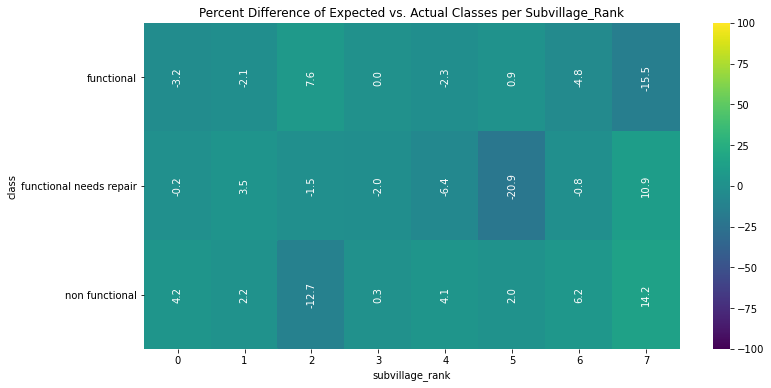

In [63]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'subvillage_rank')

### LGA
Let's take a further look at some of the geographic data in column lga

In [64]:
data['lga'].value_counts().tail(35)

Tandahimba          266
Misenyi             260
Handeni             254
Chato               236
Ileje               231
Newala              231
Bahi                224
Kisarawe            223
Temeke              215
Rorya               210
Tarime              209
Ngorongoro          201
Kiteto              193
Shinyanga Urban     191
Monduli             189
Sumbawanga Urban    180
Singida Urban       177
Sikonge             170
Kilindi             161
Nanyumbu            158
Tabora Urban        155
Liwale              154
Ilemela             142
Mafia               132
Mtwara Urban        124
Tanga                99
Morogoro Urban       96
Kinondoni            93
Bukoba Urban         88
Songea Urban         80
Moshi Urban          79
Kigoma Urban         71
Arusha Urban         63
Lindi Urban          21
Nyamagana             1
Name: lga, dtype: int64

In [65]:
data['lga'].nunique()

125

In [66]:
data['lga'].str.contains('Urban|urban|Rural|rural').sum()

11235

Similar to what we did with subvillage, we will keep only the categories with large numbers of well points. Since only 1 category besides other has more than 2000 well points we will modify this into a binary column for lga_Njombe. 

In [67]:
data['urban_rural'] = 'unknown'
data.loc[data['lga'].str.contains('Rural|rural'), 'urban_rural'] = 'rural'
data.loc[data['lga'].str.contains('Urban|urban'), 'urban_rural'] = 'urban'

In [68]:
data['urban_rural']

0        unknown
1        unknown
2        unknown
3        unknown
4        unknown
          ...   
59395    unknown
59396    unknown
59397    unknown
59398    unknown
59399      rural
Name: urban_rural, Length: 59400, dtype: object

In [69]:
counts = data['lga'].value_counts()
counts = counts.loc[counts >=500]
counts = list(counts.index)
data.loc[~data['lga'].isin(counts), 'lga'] = 'other'

P-Value = 0.0
Chi Statistic = 9320.84546564332
Degrees of Freedom = 96


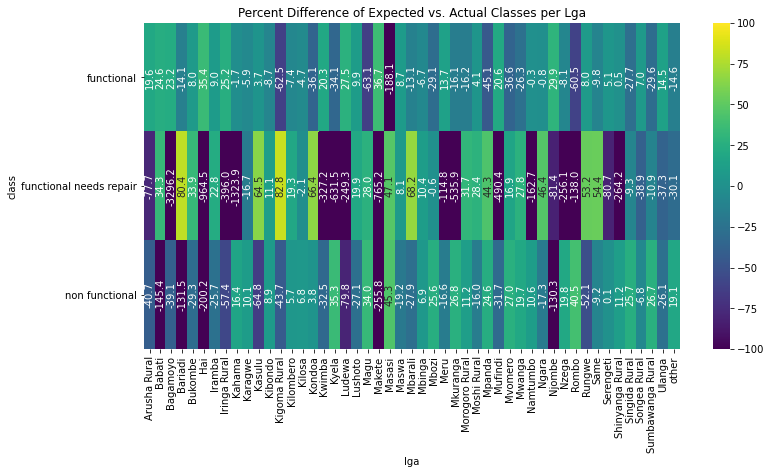

In [70]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'lga')

P-Value = 4.0468430227561945e-26
Chi Statistic = 125.24447682205827
Degrees of Freedom = 4


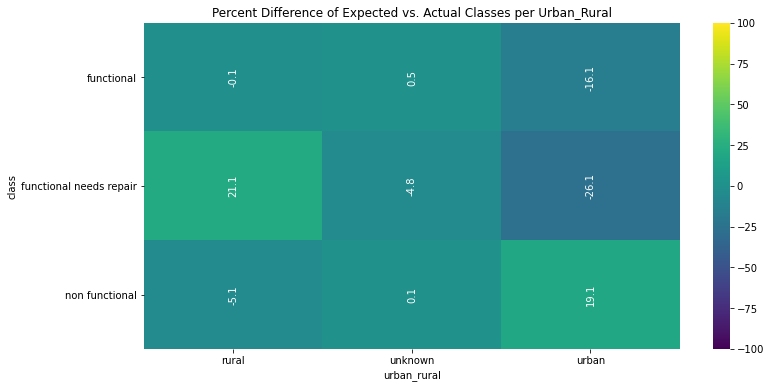

In [71]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'urban_rural')

### Basin
Now we will look at the basin column to see if it needs any cleaning/modification.

In [72]:
data['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

We will leave the categories unaltered as it seems to have a good distribution, but we will modify some of the strings to eliminate the /'s

In [73]:
data['basin'].replace({'Ruvuma / Southern Coast':'Ruvuma-Southern_Coast',
                     'Wami / Ruvu':'Wami-Ruvu'}, inplace=True)
data['basin'].unique()

array(['Lake Nyasa', 'Lake Victoria', 'Pangani', 'Ruvuma-Southern_Coast',
       'Internal', 'Lake Tanganyika', 'Wami-Ruvu', 'Rufiji', 'Lake Rukwa'],
      dtype=object)

P-Value = 0.0
Chi Statistic = 1921.0342260111142
Degrees of Freedom = 16


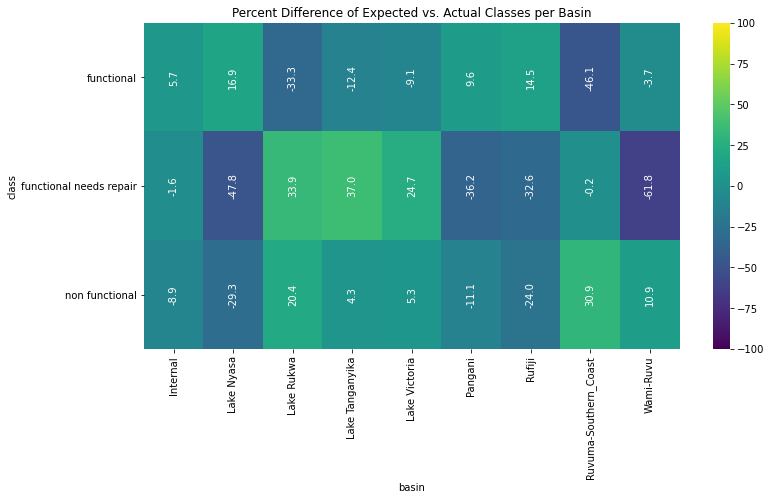

In [74]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'basin')

### Ward
Let's take a look at ward. We can check if it matches up with the subvillage column in which case we will simply drop it to avoid colinearity. If not it is likely to be another column with many categories that will need to have categories with smaller counts combined.

In [75]:
data['ward'].value_counts().head(30)

Igosi            307
Imalinyi         252
Siha Kati        232
Mdandu           231
Nduruma          217
Kitunda          203
Mishamo          203
Msindo           201
Chalinze         196
Maji ya Chai     190
Usuka            187
Ngarenanyuki     172
Chanika          171
Vikindu          162
Mtwango          153
Matola           145
Zinga/Ikerege    141
Maramba          139
Wanging'ombe     139
Itete            137
Magomeni         135
Ifakara          134
Kikatiti         134
Olkokola         133
Maposeni         130
Mvomero          129
Igongolo         129
Mlangali         125
Nkoma            122
Nkungulu         121
Name: ward, dtype: int64

In [76]:
(data['ward']==data['subvillage']).sum()

9

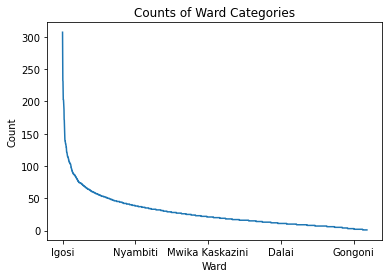

In [77]:
data['ward'].value_counts().plot()
plt.title('Counts of Ward Categories')
plt.xlabel('Ward')
plt.ylabel('Count')
plt.show()

We can break the wards in five categories: verybig, big, medium, small and verysmall. If we find these are important features for the model then we can also come back and expand on the amount of categories.

In [78]:
counts = data['ward'].value_counts()
verybig = counts.loc[counts.between(200,400)].index
big = counts.loc[counts.between(100,200)].index
medium = counts.loc[counts.between(50,100)].index
small = counts.loc[counts.between(25,50)].index
verysmall = counts.loc[counts.between(15,25)].index
smaller = counts.loc[counts.between(5,15)].index
smallest = counts.loc[counts.between(2,5)].index
single = counts.loc[counts ==1].index
data.loc[data['ward'].isin(verybig), 'ward_rank'] = 7
data.loc[data['ward'].isin(big), 'ward_rank'] = 6
data.loc[data['ward'].isin(medium), 'ward_rank'] = 5
data.loc[data['ward'].isin(small), 'ward_rank'] = 4
data.loc[data['ward'].isin(verysmall), 'ward_rank'] = 3
data.loc[data['ward'].isin(smaller), 'ward_rank'] = 2
data.loc[data['ward'].isin(smallest), 'ward_rank'] = 1
data.loc[data['ward'].isin(single), 'ward_rank'] = 0

In [79]:
counts = data['ward'].value_counts()
counts = counts.loc[counts >=100]
counts = list(counts.index)
data.loc[~data['ward'].isin(counts), 'ward'] = 'other'

In [80]:
data['ward'].unique()

array(['other', 'Msindo', 'Nkoma', 'Mdandu', 'Usuka', 'Matola', 'Kimochi',
       'Siha Kati', 'Chalinze', 'Mtwango', 'Nduruma', 'Makwale',
       'Kagongo', 'Kikatiti', 'Imalinyi', 'Masama Mashariki',
       'Maji ya Chai', 'Lupalilo', 'Itete', 'Mvomero', 'Kitunda',
       'Mahongole', 'Rujewa', "Wanging'ombe", 'Chinamili', 'Mkongo',
       'Ifakara', 'Ngarenanyuki', 'Mishamo', 'Olkokola', 'Kanga',
       'Nkungulu', 'Kidatu', 'Mabwerebwere', 'Mamire', 'Kiranyi',
       'Vikindu', 'Zinga/Ikerege', 'Soga', 'Magomeni', 'Tinde',
       'Diongoya', 'Hedaru', 'Yombo', 'Makuyuni', 'Chanika', 'Bugarama',
       'Maramba', 'Igosi', 'Malindi', 'Masama Magharibi', 'Ihanda',
       'Isongole', 'Mlangali', 'Igongolo', 'Maposeni', 'Mahembe', 'Simbo',
       'Siha Mashariki'], dtype=object)

P-Value = 0.0
Chi Statistic = 1673.5892802311087
Degrees of Freedom = 14


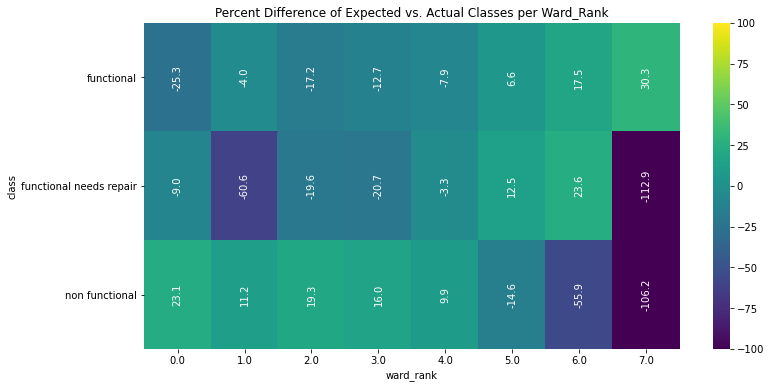

In [81]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'ward_rank')

### Region

In [82]:
data['region'].unique()

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

In [83]:
data['region_code'].unique()

array([11, 20, 21, 90, 18,  4, 17, 14, 60, 10,  3, 15, 19, 16, 80,  1,  6,
        2, 12, 13,  5,  7, 99, 24,  9,  8, 40], dtype=int64)

We will drop the region column and keep the region code column as region code has more categories. Without further outside research we can't determine the match up between the regions and the region codes and therefore can't confirm there collinearity.

P-Value = 0.0
Chi Statistic = 6237.405358612225
Degrees of Freedom = 52


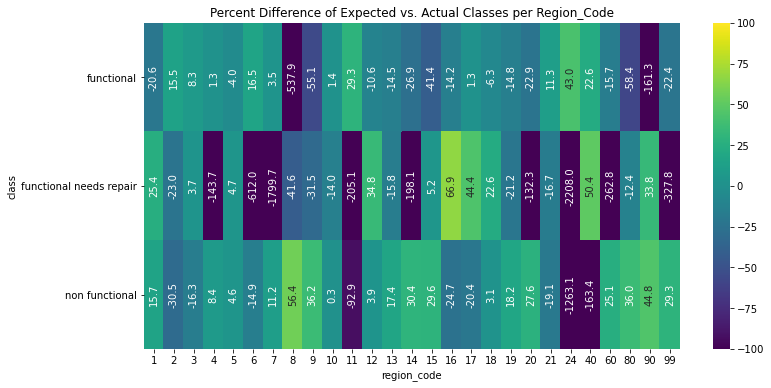

In [84]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'region_code')

In [85]:
data.drop(columns=['region'], inplace=True)
data.columns

Index(['id', 'class', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'subvillage',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type', 'water_quality_rank',
       'quantity_rank', 'quant_qual_rank', 'subvillage_rank', 'urban_rural',
       'ward_rank'],
      dtype='object')

### District Code
Let's take a look at the district code column and see if it differs greatly from the region_code column

In [86]:
data['district_code'].nunique(), data['district_code'].unique()

(20,
 array([ 5,  2,  4, 63,  1,  8,  3,  6, 43,  7, 23, 33, 53, 62, 60, 30, 13,
         0, 80, 67], dtype=int64))

In [87]:
data.loc[data['district_code']==data['region_code']]['region_code'].count()

3266

P-Value = 0.0
Chi Statistic = 1772.655971418982
Degrees of Freedom = 38


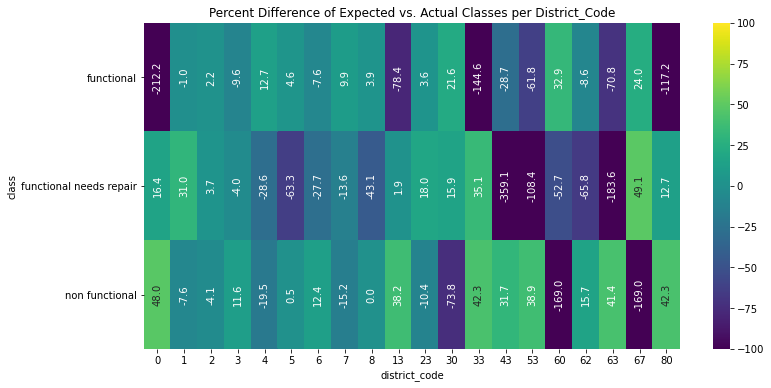

In [88]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'district_code')

Based on there being limited times where the district_code is the same as the region_code and that we don't have a better definition for either variable, we will keep both

## Date/Time Information
### Date Recorded (Month, Year)
Lets' look into the dates recorded column to see if there are any trends. We will start with tranforming it into a datetime object and then extract the month and year into seperate columns for simpler viewing.

In [89]:
data['date_recorded']= pd.to_datetime(values['date_recorded'])

In [90]:
data['date_recorded'].describe(datetime_is_numeric=True)

count                            59400
mean     2012-03-29 09:11:33.818181888
min                2002-10-14 00:00:00
25%                2011-04-01 00:00:00
50%                2012-10-10 00:00:00
75%                2013-02-09 00:00:00
max                2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [91]:
data['date_recorded'].dt.year.value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: date_recorded, dtype: int64

In [92]:
data['year']=data['date_recorded'].dt.year
data['month']=data['date_recorded'].dt.month
data[['month', 'year']]

month  year
0          3  2011
1          3  2013
2          2  2013
3          1  2013
4          7  2011
...      ...   ...
59395      5  2013
59396      5  2011
59397      4  2011
59398      3  2011
59399      3  2011

[59400 rows x 2 columns]

As we did before let's take a look at the percentages for each label by month to see how it matches up with the overall percentages.

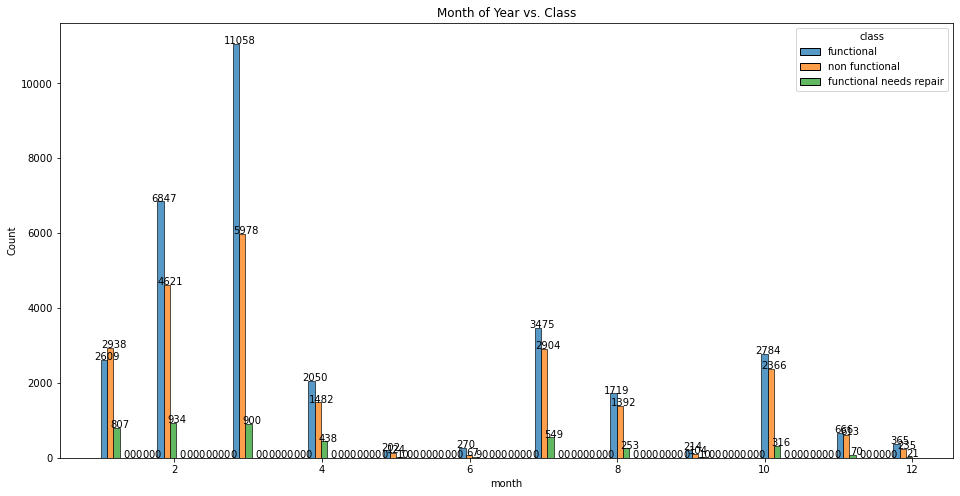

In [93]:
plt.figure(figsize=(16, 8))
ax=sns.histplot(data=data, x='month', hue='class', multiple='dodge')
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2)+.05, y=height+0.25, s=height, ha='center')
plt.title('Month of Year vs. Class')
plt.show()

There appears to be a some seasonality to when inspections are performed. This possibly coincides with wet and dry seasons in the region. Persons managing the wellpoints would typically have additional inspections before and during times of use to ensure limited down time during the peak demand. It would be expected that all types of wellpoints would have better water access during a wet season as groundwater levels rise, though we don't know how this becomes associated with demand as more non-wellpoint bodies of water are likely available at the same time. 

P-Value = 3.724601066116824e-274
Chi Statistic = 1359.4411197501354
Degrees of Freedom = 22


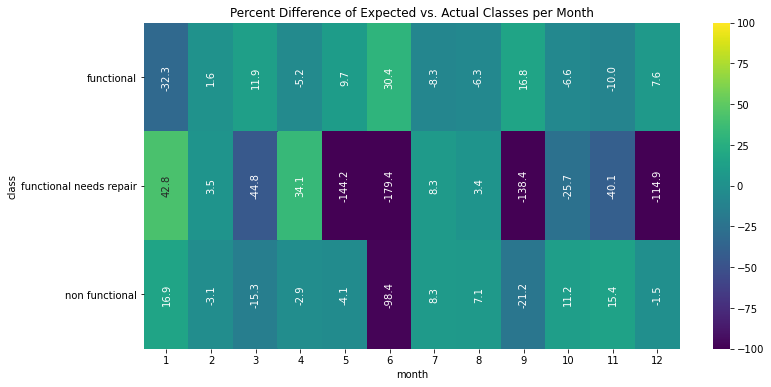

In [94]:
#Reviewing counts of labels per each month
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'month')

There does appear to be a difference month to month in level of functioning equipment. Let's take a look further at a single year

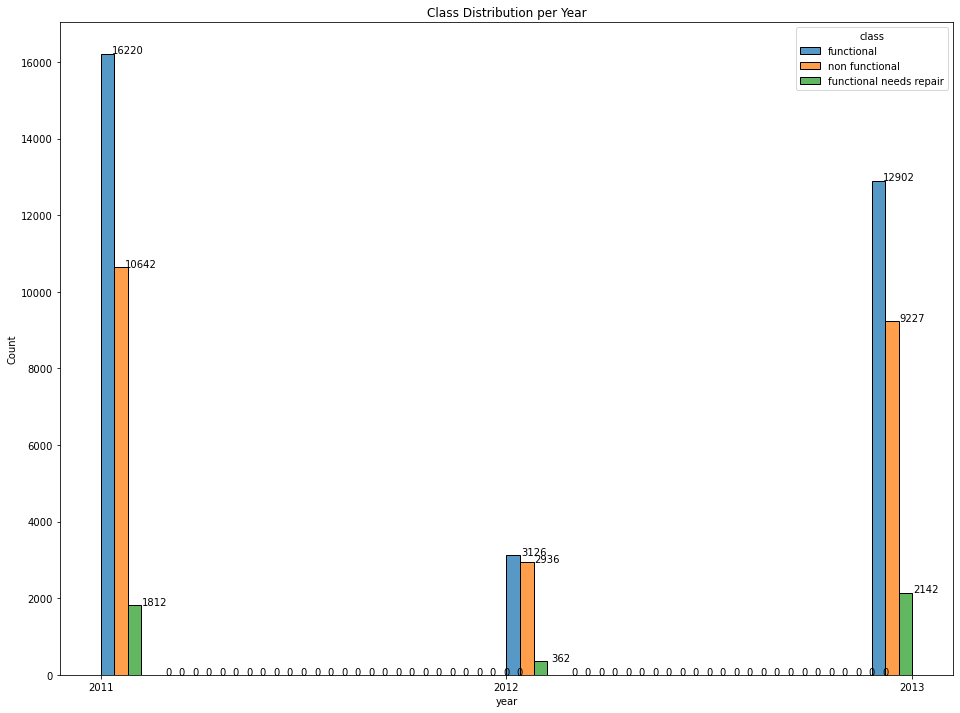

In [95]:
plt.figure(figsize=(16, 12))
ax=sns.histplot(data=data.loc[data['year']>2010], x='year', hue='class', multiple='dodge')
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2)+.05, y=height+0.25, s=height, ha='center')
plt.xticks([2011, 2012, 2013])
plt.title('Class Distribution per Year')
plt.show()

2011 and 2013 have simliar distributions of each class. 2012 appears to have a higher percentage of non functional class but we don't know if that was more a by product of the samller smaple size of inspections. Without knowing the reason for the considerable drop in inspections, we can't confidently say that there was a different distribution of classes.

P-Value = 2.8010939234054937e-200
Chi Statistic = 952.3981269545478
Degrees of Freedom = 8


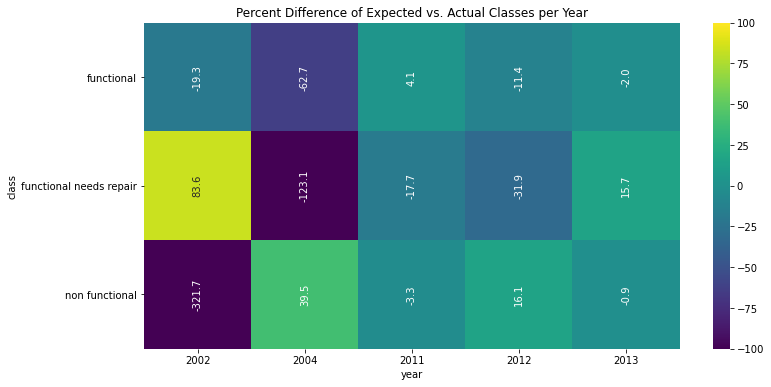

In [96]:
#Reviewing counts of labels per each year
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'year')

### Construction Year
Let's continue by looking at construction_year and transforming it into a years old column

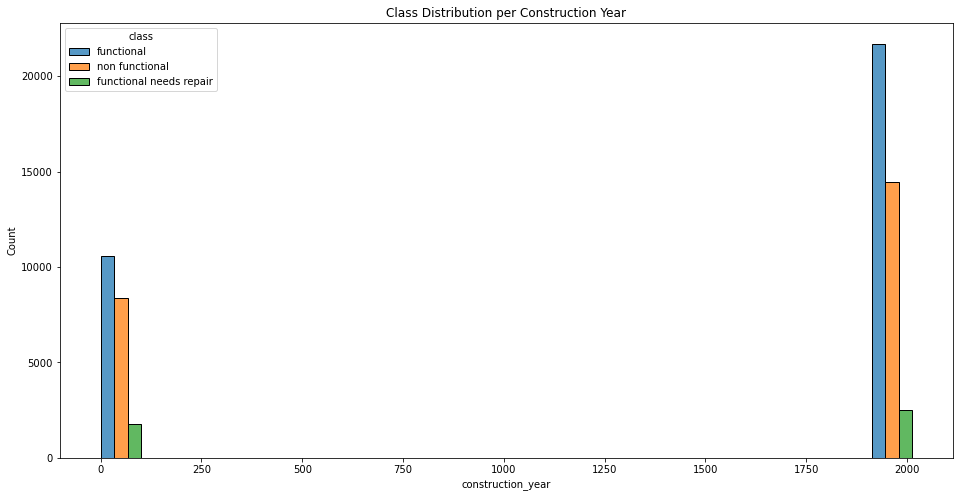

In [97]:
plt.figure(figsize=(16,8))
sns.histplot(data=data, x='construction_year', hue='class', multiple='dodge', bins=20)
plt.title('Class Distribution per Construction Year')
plt.show()

In [98]:
data['construction_year'].describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

As it is a float and seems to have many zeros we will have to make some corrections

In [99]:
#lets look at how the data is spread out
data['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [100]:
#looking just at the non zero data
data.loc[data['construction_year']>0,'construction_year'].describe()

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

We will use 1999 as a fill in date for the zeroes. This is based on the nonzero entries having a mean of ~1997 and a median of 2000. We will also convert it to a datetime object

In [101]:
data['construction_year'] = values['construction_year']

In [102]:
used = ['latitude', 'longitude', 'extraction_type', 'source', 'waterpoint_type']

data.loc[data['construction_year']==0, 'construction_year'] = 1950
data['construction_year'] = pd.to_datetime(data['construction_year'], format='%Y')
data['construction_year'] = data['construction_year'].dt.year

old_X = data.loc[data['construction_year']!=1950, used]
old_X_dum = pd.get_dummies(old_X)
old_y = data.loc[data['construction_year']!=1950, ['construction_year']]
knn_old = KNeighborsRegressor(n_neighbors=1)
knn_old.fit(old_X_dum, old_y)
predictor = pd.get_dummies(data.loc[data['construction_year']==1950, used])
data.loc[data['construction_year']==1950, ['construction_year']] = knn_old.predict(predictor)

In [103]:
data['construction_year'] = data['construction_year'].astype('int')

In [104]:
data['years_old'] = data['date_recorded'].dt.year - data['construction_year']

In [105]:
data.years_old.describe()

count    59400.000000
mean        15.136768
std         11.886258
min         -7.000000
25%          5.000000
50%         13.000000
75%         23.000000
max         53.000000
Name: years_old, dtype: float64

In [106]:
data.loc[data['years_old']<0, 'years_old'] = 1

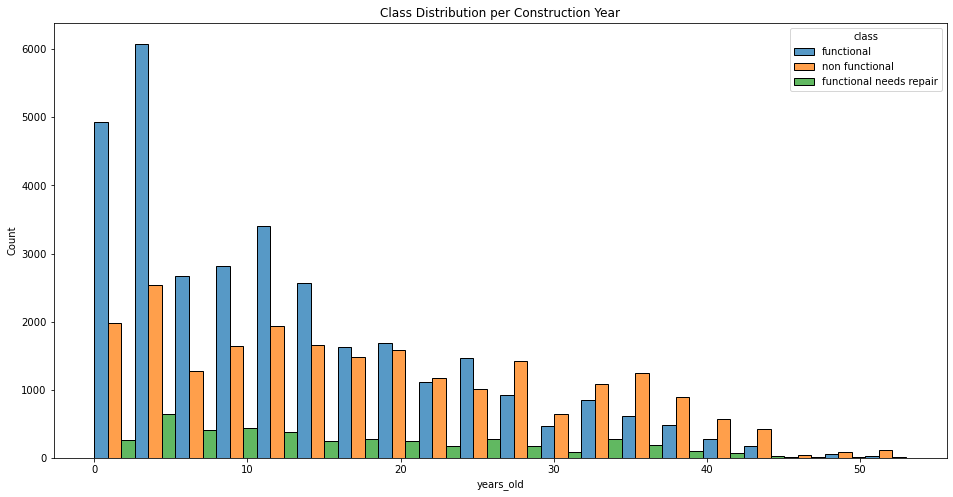

In [107]:
plt.figure(figsize=(16,8))
sns.histplot(data=data, x='years_old', hue='class', multiple='dodge', bins=20)
plt.title('Class Distribution per Construction Year')
plt.show()

In [108]:
data.drop(columns=['date_recorded', 'construction_year'], inplace=True)

## Administrative Information

### Public Meeting/Permit
We can set the the permit and public meeting columns to be 0 and 1 instead of True and False to make them easier for model ingestion

In [109]:
data['public_meeting'] = data['public_meeting'].map({True:1, False:0})

P-Value = 1.213534187403987e-68
Chi Statistic = 312.76449881049086
Degrees of Freedom = 2


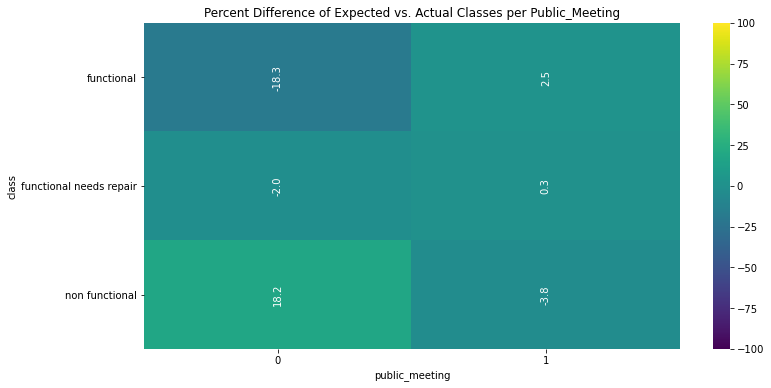

In [110]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'public_meeting')

In [111]:
data['permit'] = data['permit'].map({True:1, False:0})

P-Value = 3.03134017714568e-14
Chi Statistic = 62.254372954988035
Degrees of Freedom = 2


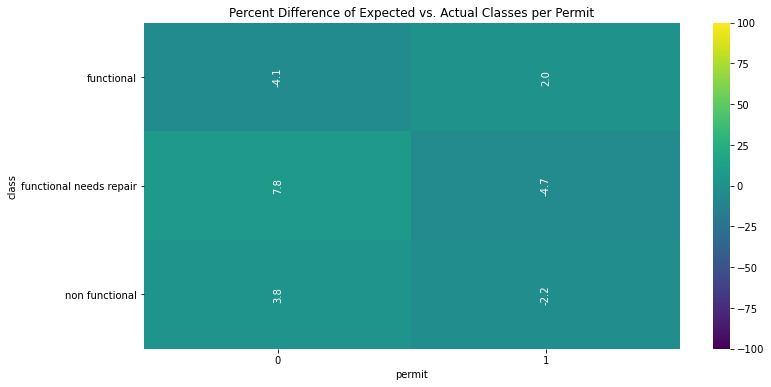

In [112]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'permit')

### Scheme

In [113]:
data['scheme_management'].value_counts(), data['scheme_name'].value_counts()

(VWC                 36793
 WUG                  5206
 unknown              3877
 Water authority      3153
 WUA                  2883
 Water Board          2748
 Parastatal           1680
 Private operator     1063
 Company              1061
 Other                 766
 SWC                    97
 Trust                  72
 None                    1
 Name: scheme_management, dtype: int64,
 unknown                     28166
 K                             682
 None                          644
 Borehole                      546
 Chalinze wate                 405
                             ...  
 Sori                            1
 KWA                             1
 Mrangamiza spring source        1
 Zimba water supply              1
 Welela Shallow well             1
 Name: scheme_name, Length: 2697, dtype: int64)

The two scheme columns have different enough infomration to keep both. The scheme management column with be left alone except for moving the 1 'None' value into the 'other' category. The scheme name column will need to have it's categories paired down.

In [114]:
data['scheme_name'].value_counts().head(20)

unknown                                  28166
K                                          682
None                                       644
Borehole                                   546
Chalinze wate                              405
M                                          400
DANIDA                                     379
Government                                 320
Ngana water supplied scheme                270
wanging'ombe water supply s                261
wanging'ombe supply scheme                 234
Bagamoyo wate                              229
I                                          229
Uroki-Bomang'ombe water sup                209
N                                          204
Kirua kahe gravity water supply trust      193
Machumba estate pipe line                  185
Makwale water supplied sche                166
Kijiji                                     161
S                                          154
Name: scheme_name, dtype: int64

In [115]:
counts2 = data['scheme_name'].value_counts()
counts2 = counts2.loc[counts2 >=200]
counts2 = list(counts2.index)
data.loc[~data['scheme_name'].isin(counts2), 'scheme_name'] = 'other'

In [116]:
data['scheme_name'].unique()

array(['other', 'unknown', 'None', "wanging'ombe water supply s",
       'Chalinze wate', 'Ngana water supplied scheme', 'K', 'M',
       "wanging'ombe supply scheme", 'Bagamoyo wate', 'N', 'Borehole',
       'DANIDA', 'Government', "Uroki-Bomang'ombe water sup", 'I'],
      dtype=object)

P-Value = 0.0
Chi Statistic = 1929.6541363281242
Degrees of Freedom = 30


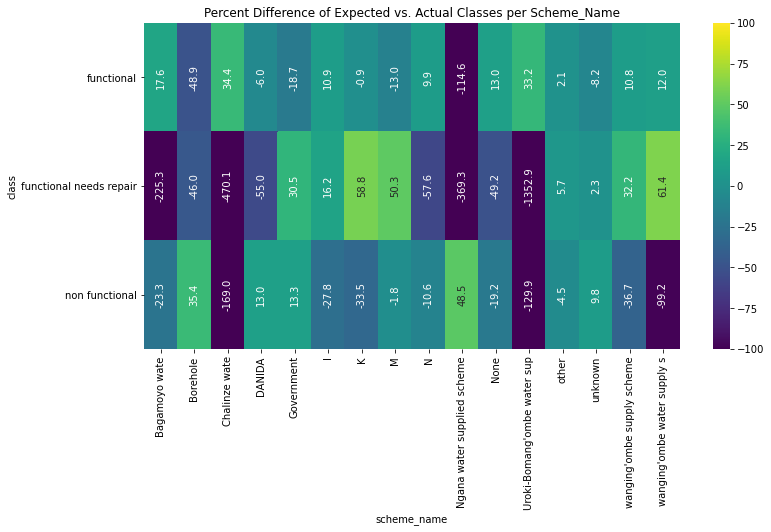

In [117]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'scheme_name')

### Management

In [118]:
data['management'].value_counts(), data['management_group'].value_counts()

(vwc                 40507
 wug                  6515
 water board          2933
 wua                  2535
 private operator     1971
 parastatal           1768
 water authority       904
 other                 844
 company               685
 unknown               561
 other - school         99
 trust                  78
 Name: management, dtype: int64,
 user-group    52490
 commercial     3638
 parastatal     1768
 other           943
 unknown         561
 Name: management_group, dtype: int64)

P-Value = 0.0
Chi Statistic = 2311.204866749453
Degrees of Freedom = 22


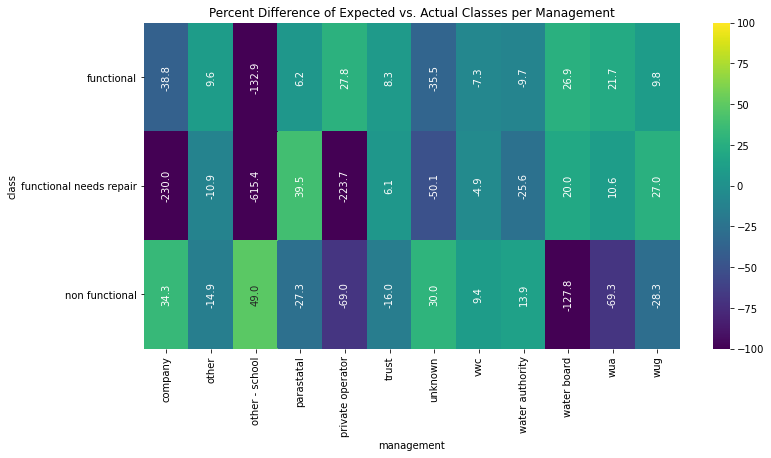

In [119]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'management')

We will keep both columns unchanged. 

### Funder
Let's take a look into the installer and funder columns

In [120]:
data['funder'].value_counts().head(35)

Government Of Tanzania    9084
unknown                   3635
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
0                          777
Norad                      765
Germany Republi            610
Tcrs                       602
Ministry Of Water          590
Water                      583
Dwe                        484
Netherlands                470
Hifab                      450
Adb                        448
Lga                        442
Amref                      425
Fini Water                 393
Oxfam                      359
Wateraid                   333
Rc Church                  321
Isf                        316
Rudep                      312
Mission 

As with our previous categorical columns, there are a lot of categpories that have very small counts. We will compbine them into a single other category and keep the categories with larger counts seperated.

As with our previous categorical columns, there are a lot of categpories that have relatively small counts. We will combine them into a single other category and keep the categories with larger counts seperated. The number for seperation is a guess for the time being and we can come back and adjust it if we find this to be an important feature to the model.

In [121]:
counts3 = data['funder'].value_counts()
counts3 = counts3.loc[counts3 >=500]
counts3 = list(counts3.index)
data.loc[~data['funder'].isin(counts3), 'funder'] = 'other'

In [122]:
data['funder'].unique()

array(['other', 'Unicef', 'Dwsp', 'Rwssp', 'Danida', 'World Vision',
       'Hesawa', 'Government Of Tanzania', 'Water', 'Private Individual',
       'unknown', 'District Council', 'Kkkt', 'Norad', 'Tcrs',
       'Germany Republi', 'Tasaf', 'World Bank', '0', 'Dhv',
       'Ministry Of Water'], dtype=object)

P-Value = 0.0
Chi Statistic = 4484.538064949011
Degrees of Freedom = 40


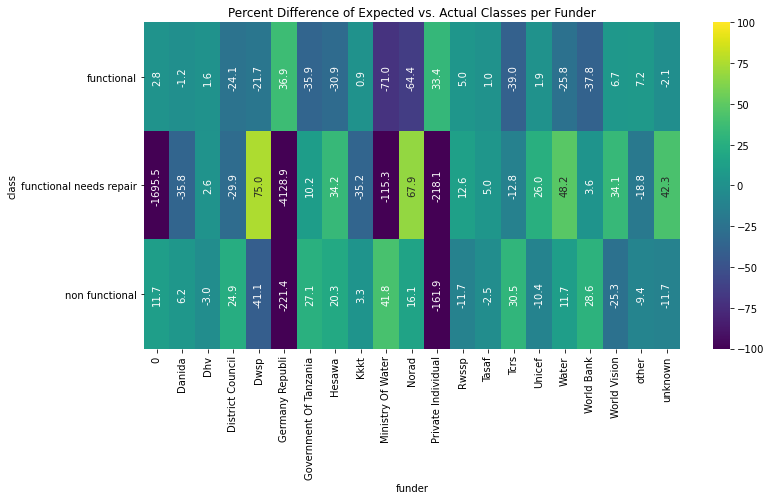

In [123]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'funder')

### Installer

In [124]:
data['installer'].value_counts().head(35)

DWE                   17402
unknown                3656
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
LGA                     408
World vision            408
WEDECO                  397
TASAF                   396
District council        392
Gover                   383
AMREF                   329
TWESA                   316
WU                      301
Dmdd                    287
ACRA                    278
World Vision            270
SEMA                    249
DW                      246
OXFAM                   234
Da                      224
Idara ya maji           222
UNICEF                  222
Gove                    222
Name: installer, dty

As with our previous categorical columns, there are a lot of categpories that have relatively small counts. We will combine them into a single other category and keep the categories with larger counts seperated. The number for seperation is a guess for the time being and we can come back and adjust it if we find this to be an important feature to the model.

In [125]:
counts4 = data['installer'].value_counts()
counts4 = counts4.loc[counts4 >=500]
counts4 = list(counts4.index)
data.loc[~data['installer'].isin(counts4), 'installer'] = 'other'

In [126]:
data['installer'].unique()

array(['other', 'DWE', 'DANIDA', 'unknown', 'Central government', 'Commu',
       'Government', 'KKKT', 'RWE', 'HESAWA', 'Community', 'CES',
       'Hesawa', '0', 'DANID', 'TCRS', 'District Council'], dtype=object)

P-Value = 0.0
Chi Statistic = 3594.631187886241
Degrees of Freedom = 32


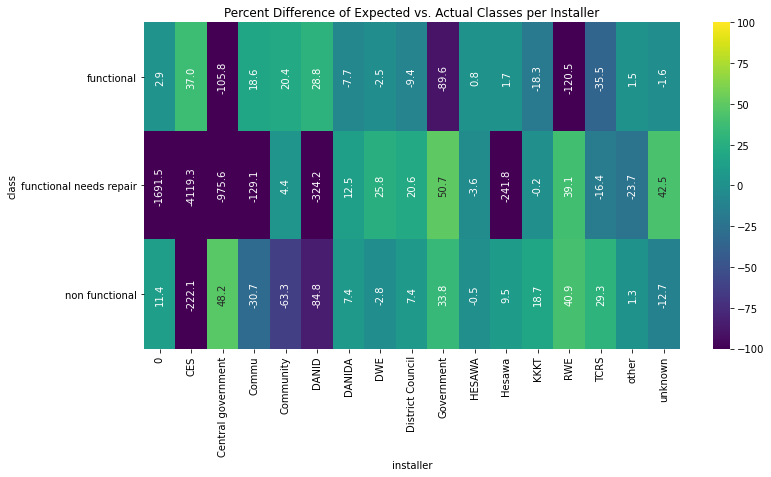

In [127]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'installer')

In [128]:
data['fund_inst_same'] = 0
data.loc[data['funder']==data['installer'],['fund_inst_same']] = 1

P-Value = 3.656288369807821e-50
Chi Statistic = 227.66561224690582
Degrees of Freedom = 2


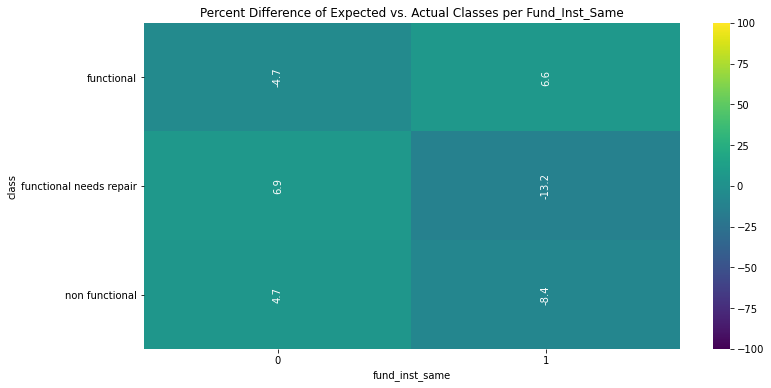

In [129]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'fund_inst_same')

### Payment
Let's take a look at the payment infomration in columns payemnt and payment_type

In [130]:
data['payment'].value_counts(), values['payment_type'].value_counts()

(never pay                25348
 pay per bucket            8985
 pay monthly               8300
 unknown                   8157
 pay when scheme fails     3914
 pay annually              3642
 other                     1054
 Name: payment, dtype: int64,
 never pay     25348
 per bucket     8985
 monthly        8300
 unknown        8157
 on failure     3914
 annually       3642
 other          1054
 Name: payment_type, dtype: int64)

It appears that the two columns were recording the same values, but that the payment_type column has many more non-other entries. We will drop the payment column to avoid collinearity.

In [131]:
data.drop(columns=['payment'], inplace=True)

P-Value = 0.0
Chi Statistic = 3965.619403974787
Degrees of Freedom = 12


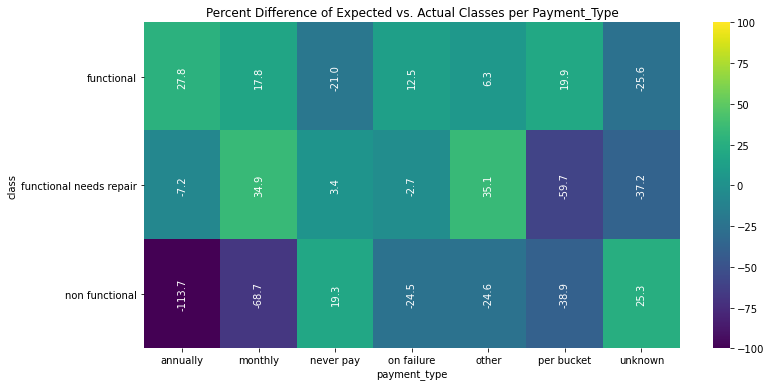

In [132]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'payment_type')

In [133]:
data['pay_rank'] = data['payment_type'].map({'annually':6, 'per bucket':5, 'monthly':4,'on failure':3, 'other':2, 'never pay':1, 'unknown':0})

## Numeric Information

### Population
We are curious to see if popultion plays a role in the distribution of classes. More population likely means more demand, but also could mean more resources in the area to fix problems more quickly and/or maintaint the wellpoint more frequently allowing for less issues leading the wellpoint being non functional

In [134]:
data['population'].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

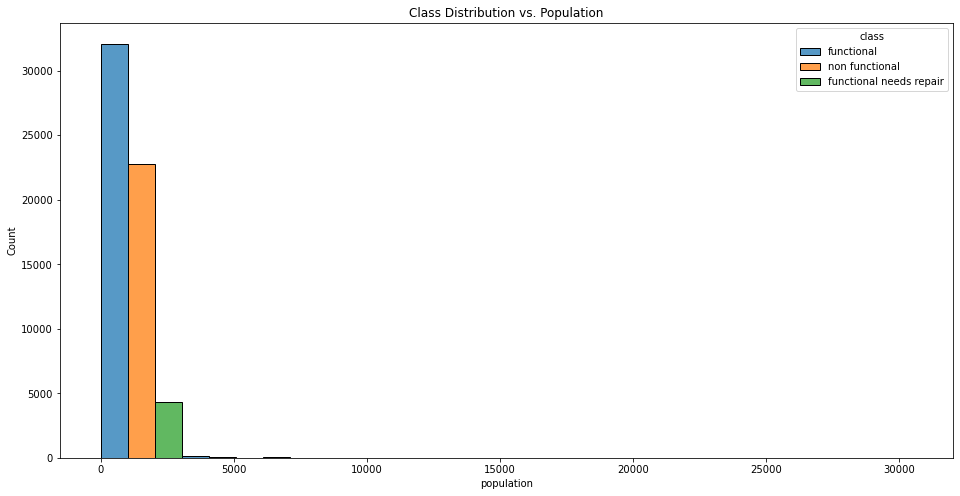

In [135]:
plt.figure(figsize=(16,8))
sns.histplot(data=data, x='population', hue='class', bins=10, multiple='dodge')
plt.title('Class Distribution vs. Population')
plt.show()

Due to the long right tail of the data it is difficult to see where the distribution of the lower end data whihc includes the majority of the data. We can look at only areas with populations between 2 and 2000. This will also eliminate the assumedly erroneaus entries of 0 and 1 for population from the visual.

In [136]:
data.loc[data['population'].between(2, 2000), 'population'].describe()

count    30512.000000
mean       287.557584
std        298.016438
min          2.000000
25%         96.000000
50%        200.000000
75%        360.000000
max       2000.000000
Name: population, dtype: float64

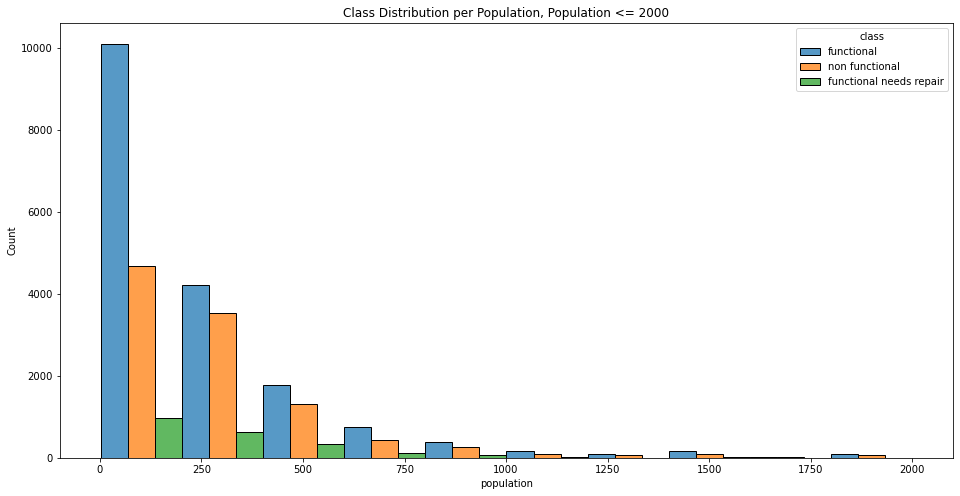

In [137]:
plt.figure(figsize=(16,8))
sns.histplot(data=data.loc[data['population'].between(2,2000)], x='population', hue='class', bins=10, multiple='dodge')
plt.title('Class Distribution per Population, Population <= 2000')
plt.show()

We will create a new bin column for population with additional bins at the lower end.

In [138]:
data['popbins'] = pd.cut(data['population'], [-1,2,250,500,1000,2500,10000,20000,30000,40000], labels=list(range(1,10)))

In [139]:
data['popbins']

0        2
1        3
2        2
3        2
4        1
        ..
59395    2
59396    2
59397    1
59398    1
59399    2
Name: popbins, Length: 59400, dtype: category
Categories (9, int64): [1 < 2 < 3 < 4 ... 6 < 7 < 8 < 9]

P-Value = 0.0
Chi Statistic = 1794.1746476716419
Degrees of Freedom = 16


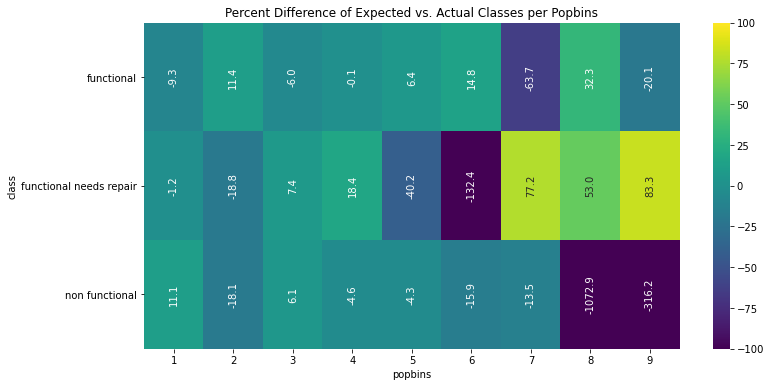

In [140]:
#Let's take a look at a comparison of classes and sources
Chi_sq_test(data, 'class', 'popbins')

### GPS Height
We can now look into the gps height column by comapring it to latitude and longitude as there should be some correlation based on the terrain of the country

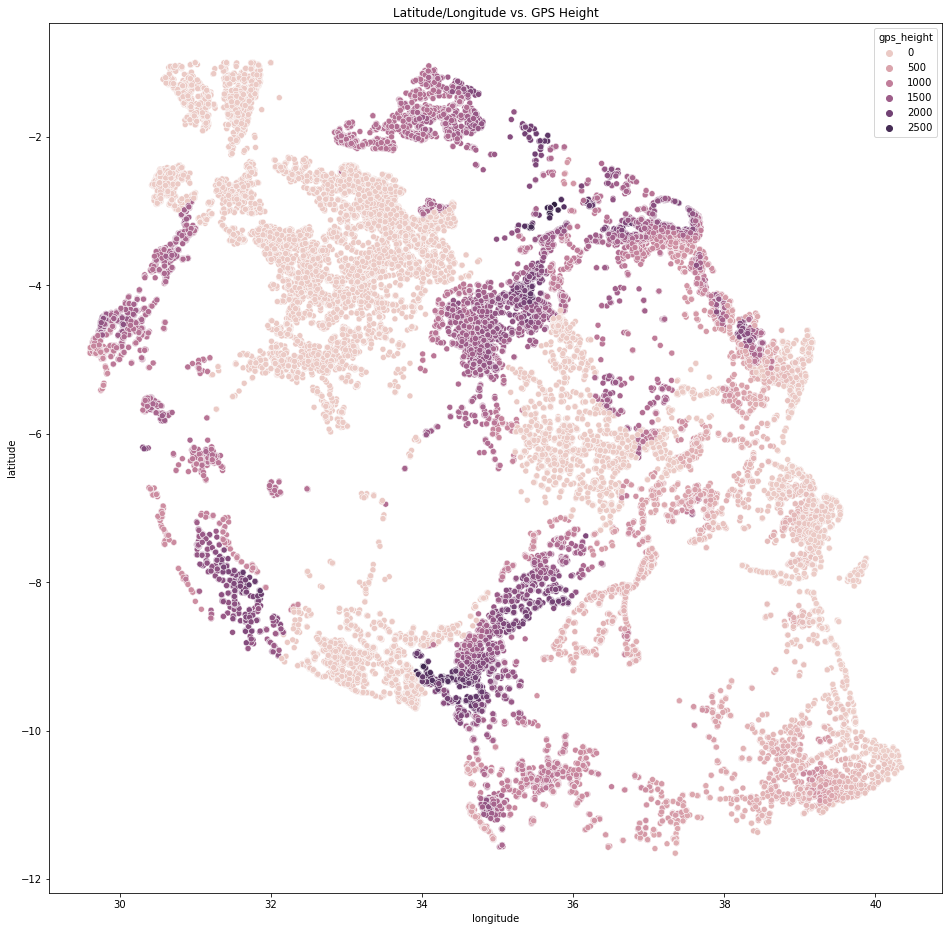

In [141]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data, y='latitude', x='longitude', hue='gps_height')
plt.title('Latitude/Longitude vs. GPS Height')
plt.show()

In [142]:
data['gps_height'].describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

In [143]:
data.loc[data['gps_height']>0, 'gps_height'].describe()

count    37466.000000
mean      1060.341803
std        587.707607
min          1.000000
25%        471.000000
50%       1194.000000
75%       1512.000000
max       2770.000000
Name: gps_height, dtype: float64

In [144]:
gps_trialX = data.loc[data['gps_height']>0, ['latitude', 'longitude']]
gps_trialy = data.loc[data['gps_height']>0, ['gps_height']]

X, tX, y, ty = train_test_split(gps_trialX, gps_trialy, test_size=0.25, random_state=42)
score={}
for i in range(1,11):
    knn_gps_trial = KNeighborsRegressor(n_neighbors=i, weights='distance', metric='euclidean')
    knn_gps_trial.fit(X, y)
    score[i] = knn_gps_trial.score(tX, ty)
score

{1: 0.998051758096672,
 2: 0.9981721900357545,
 3: 0.9982835702388516,
 4: 0.9980924704600418,
 5: 0.9979766442921506,
 6: 0.9978071918088754,
 7: 0.9976009734717514,
 8: 0.9973960373807501,
 9: 0.9972010078062813,
 10: 0.9970144496869333}

In [145]:
gps_trainX = data.loc[data['gps_height']>0, ['latitude', 'longitude']]
gps_trainy = data.loc[data['gps_height']>0, ['gps_height']]
knn_gps = KNeighborsRegressor(n_neighbors=3, weights='distance', metric='euclidean')
knn_gps.fit(gps_trainX, gps_trainy)


KNeighborsRegressor(metric='euclidean', n_neighbors=3, weights='distance')

In [146]:
data.loc[data['gps_height']<=0, ['gps_height']] = knn_gps.predict(data.loc[data['gps_height']<=0, 
                                                                           ['latitude', 'longitude']])

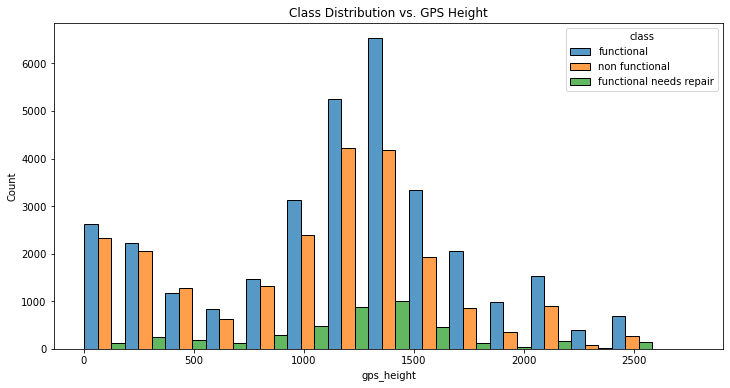

In [147]:
plt.figure(figsize=(12,6))
sns.histplot(data=data, x='gps_height', hue='class', multiple='dodge', bins=15)#, element='poly', fill=False)
plt.title('Class Distribution vs. GPS Height')
plt.show()

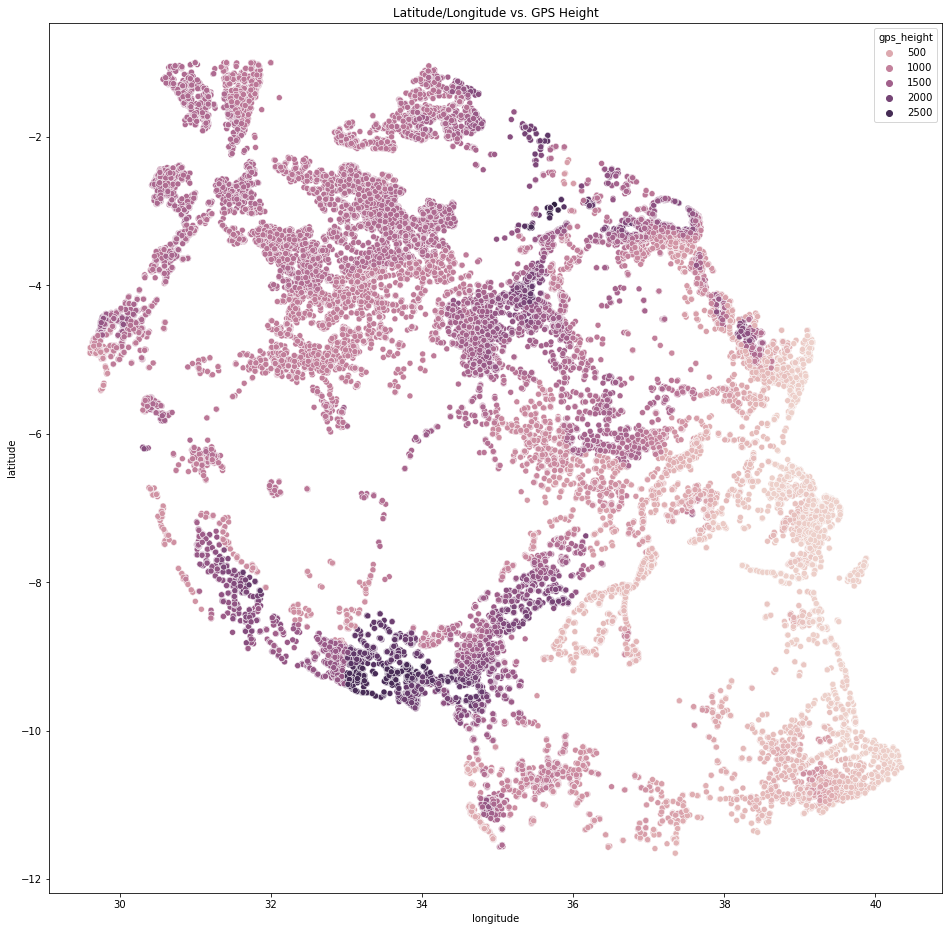

In [148]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data, y='latitude', x='longitude', hue='gps_height')
plt.title('Latitude/Longitude vs. GPS Height')
plt.show()

### Amount TSH

In [149]:
data['amount_tsh'] = data['amount_tsh'].astype('int')
data['amount_tsh'].describe()

count     59400.00000
mean        317.65037
std        2997.57456
min           0.00000
25%           0.00000
50%           0.00000
75%          20.00000
max      350000.00000
Name: amount_tsh, dtype: float64

In [150]:
data['amount_tsh'].value_counts()

0         41643
500        3102
50         2472
1000       1488
20         1463
          ...  
170000        1
12            1
250000        1
9             1
70000         1
Name: amount_tsh, Length: 96, dtype: int64

In [151]:
data.loc[data['amount_tsh']>2000, 'amount_tsh'].value_counts().head(10)

5000     450
3000     334
4000     156
2400     145
2500     139
6000     125
8000      61
10000     57
12000     51
20000     45
Name: amount_tsh, dtype: int64

In [152]:
data['amount_tsh'].sort_values().tail(20)

47201     50000
51260     50000
53968     60000
21567     70000
38137    100000
6591     100000
3228     100000
10615    117000
54595    117000
44381    117000
37459    117000
5558     117000
45470    117000
57811    117000
9917     120000
9961     138000
45067    170000
22817    200000
22191    250000
10812    350000
Name: amount_tsh, dtype: int32

We are going to seperate this into bins to allow it function better with the classification algorithims. There also appears to be some issues with the top end values as 350,000 ft of head is more than 10x the height of Mt. Everest aka not possible for static head. We will use Standard Scaler on this column during feature engineering to ensure these high values don't cause the feature to be overweighted. We are also going to cap all values as 5000 and because more than two thirds of the column is at value zero, we will turn this into a categorical column of bins and eliminate the continuous column.

In [153]:
col = ['gps_height', 'latitude', 'longitude', 'quant_qual_rank']
data['tsh_rank'] = pd.cut(data['amount_tsh'], bins=[-1,0,5,10,25,50,100,250,500,400000], labels=['error_low', 'limited', 
                                             'small', 'ok', 'medium', 'good', 'great', 'grand', 'error_high'])
tsh_trialX = data.loc[~data['tsh_rank'].isin(['error_low', 'error_high']), col]
tsh_trialy = data.loc[~data['tsh_rank'].isin(['error_low', 'error_high']), ['tsh_rank']]

X, tX, y, ty = train_test_split(tsh_trialX, tsh_trialy, test_size=0.20, random_state=42)

rf_tsh_trial = RandomForestClassifier(n_estimators=250)
rf_tsh_trial.fit(X, np.ravel(y))
rf_tsh_trial.score(tX, ty)

0.8716372021521906

In [154]:
col = ['gps_height', 'latitude', 'longitude', 'quant_qual_rank']
data['tsh_rank'] = pd.cut(data['amount_tsh'], bins=[-1,0,5,10,25,50,100,250,500,400000], labels=['error_low', 'limited', 
                                             'small', 'ok', 'medium', 'good', 'great', 'grand', 'error_high'])
tsh_X = data.loc[~data['tsh_rank'].isin(['error_low', 'error_high']), col]
tsh_y = data.loc[~data['tsh_rank'].isin(['error_low', 'error_high']), ['tsh_rank']]

rf_tsh = RandomForestClassifier(n_estimators=250)
rf_tsh.fit(tsh_X, np.ravel(tsh_y))

RandomForestClassifier(n_estimators=250)

In [155]:
data.loc[data['tsh_rank'].isin(['error_low', 'error_high']), ['tsh_rank']] = rf_tsh.predict(data.loc[data['tsh_rank'].isin(['error_low', 'error_high']), col])

In [156]:
data.loc[data['amount_tsh']>500, 'amount_tsh'] = 500
data['amount_tsh']=data['amount_tsh'].astype('int')

In [157]:
data

id           class  amount_tsh           funder   gps_height  \
0      69572      functional         500            other  1390.000000   
1       8776      functional           0            other  1399.000000   
2      34310      functional          25            other   686.000000   
3      67743  non functional           0           Unicef   263.000000   
4      19728      functional           0            other  1328.294354   
...      ...             ...         ...              ...          ...   
59395  60739      functional          10  Germany Republi  1210.000000   
59396  27263      functional         500            other  1212.000000   
59397  37057      functional           0          unknown  1058.612297   
59398  31282      functional           0            other   888.993413   
59399  26348      functional           0       World Bank   191.000000   

      installer  longitude   latitude                  basin subvillage  ...  \
0         other  34.938093  -9.856322             Lake Nyasa      other  ...   
1         other  34.698766  -2.147466          Lake Victoria      other  ...   
2         other  37.460664  -3.821329                Pangani    Majengo  ...   
3         other  38.486161 -11.155298  Ruvuma-Southern_Coast      other  ...   
4         other  31.130847  -1.825359          Lake Victoria      other  ...   
...         ...        ...        ...                    ...        ...  ...   
59395       CES  37.169807  -3.253847                Pangani      other  ...   
59396     other  35.249991  -9.070629                 Rufiji      other  ...   
59397   unknown  34.017087  -8.750434                 Rufiji      other  ...   
59398     other  35.861315  -6.378573                 Rufiji      other  ...   
59399     other  38.104048  -6.747464              Wami-Ruvu      other  ...   

       subvillage_rank  urban_rural ward_rank  year  month  years_old  \
0                    2      unknown       4.0  2011      3         12   
1                    1      unknown       5.0  2013      3          3   
2                    7      unknown       2.0  2013      2          4   
3                    3      unknown       4.0  2013      1         27   
4                    1      unknown       2.0  2011      7          3   
...                ...          ...       ...   ...    ...        ...   
59395                1      unknown       6.0  2013      5         14   
59396                2      unknown       5.0  2011      5         15   
59397                1      unknown       5.0  2011      4         12   
59398                3      unknown       3.0  2011      3         15   
59399                0        rural       5.0  2011      3          9   

      fund_inst_same pay_rank  popbins tsh_rank  
0                  1        6        2    grand  
1                  1        1        3    great  
2                  1        5        2       ok  
3                  0        1        2   medium  
4                  1        1        1    grand  
...              ...      ...      ...      ...  
59395              0        5        2    small  
59396              1        6        2     good  
59397              1        4        1    grand  
59398              1        1        1    grand  
59399              0        3        2       ok  

[59400 rows x 40 columns]

Let's see visually if the ratio of functional to non functional seems to improve based on higher tsh

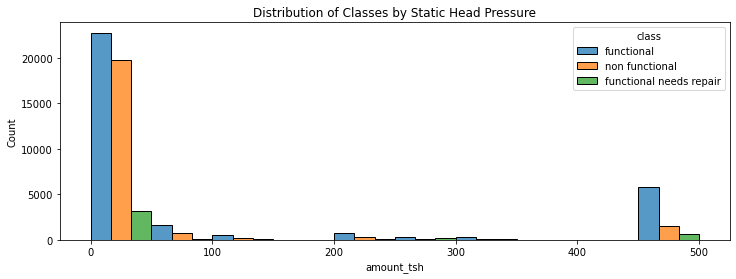

In [158]:
plt.figure(figsize=(12,4))
sns.histplot(data = data[['amount_tsh', 'class']], x='amount_tsh', hue='class', multiple='dodge', bins=10)
plt.title('Distribution of Classes by Static Head Pressure')
plt.show()

Not suprisingly the more head available the higher the percentage of wellpoints are functional. This makes sense when you consider that higher head pressures would be able to more easily push through mechancial issues like lack of lubrication as well as dirt build up in piping. We assuming that these are common cause of non functional class.

While we have further EDA and cleaning that could be done we are going to move forward at this point to see how our model performs with what we currently have. We can always come back and adjust the number of bins for a category and or maxes and mins for continuous variables.

In [159]:
#old_trialX = values.loc[values['construction_year']!=1950, used]
#old_trialX_dum = pd.get_dummies(old_trialX)
#old_trialy = values.loc[values['construction_year']!=1950, ['construction_year']]#

#X, tX, y, ty = train_test_split(old_trialX_dum, old_trialy, test_size=0.25, random_state=42)
#score={}
#mae = {}
#for i in range(1,11):
#    knn_trial = KNeighborsRegressor(n_neighbors=i)
#    knn_trial.fit(X, y)
#    score[i] = knn_trial.score(tX, ty)
#    pred = knn_trial.predict(tX)
#    mae[i] = mean_absolute_error(ty, pred)
#score, mae

We can create a single function that will perform all of our adjustments above. This will allow it to be run on the submission values as well and guarantee we are using the same process.

In [160]:
%%writefile model_prep\transformer.py 

def model_transformer_train(model_data):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    
    #Applies transformations from EDA notebook to training and testing sets to ensure same changes are made
    #Correct names in extraction_type
    data = model_data.copy()
    
    #Fill NaN values
    data.fillna(inplace=True, value={'installer':'unknown','permit':False, 'funder':'unknown', 'public_meeting':False, 
                                 'scheme_management':'unknown', 'scheme_name':'unknown', 'subvillage':'unknown'})
    
    #WATER AND EQUIPMENT INFORMATION
    #correct names in source
    data['source'].replace({'shallow well':'shallow_well',
                       'machine dbh':'machine_dbh',
                       'rainwater harvesting':'rainwater_harvesting',
                       'hand dtw':'hand_dtw'}, inplace=True)
    
    #correct extraction category names
    data['extraction_type'].replace({'other - swn 81':'other-handpump',
                                 'other - play pump':'other-handpump', 
                                 'walimi':'other-handpump', 
                                 'other - mkulima/shinyanga':'other-handpump',
                                'swn 80':'swn_80',
                                 'nira/tanira':'nira-tanira',
                                'india mark ii':'india_mark_ii',
                                'india mark iii':'india_mark_iii',
                                'other - rope pump':'other-rope_pump',}, inplace=True)
    
    #Create column for water quality and quantity and combination column of these two ranks
    data['water_quality_rank'] = data['water_quality'].map({'fluoride':7, 'soft':6, 'coloured':5,'milky':4, 
                                                        'salty':3, 'salty abandoned':2, 'fluoride abandoned':1, 
                                                       'unknown':0})
    data['quantity_rank'] = data['quantity'].map({'enough':4, 'seasonal':3, 'insufficient':2,'unknown':1, 'dry':0})
    data['quant_qual_rank']=data['quantity_rank']+data['water_quality_rank']
    
    
    #LOCATION INFORMATION
    #Latitude-Longitiude - Correct near zero values
    data.loc[data['longitude'] == 0, 'longitude'] = np.random.choice(range(31,33))
    data.loc[data['latitude']>-0.01, 'latitude'] = -1*np.random.choice(range(1,2))
    
    #Correct subvillage names with 3 or less characters based on KNeigborsRegressor and latitiude/longitude
    sv_trainX = data.loc[data['subvillage'].str.len()>3, ['latitude', 'longitude']]
    sv_trainy = data.loc[data['subvillage'].str.len()>3, ['subvillage']]
    knn_sv = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='euclidean')
    knn_sv.fit(sv_trainX, sv_trainy)
    data.loc[data['subvillage'].str.len()<=3, ['subvillage']] = knn_sv.predict(data.loc[data['subvillage'].str.len()<=3, 
                                                                           ['latitude', 'longitude']])  
    
    #Create column for size of subvillage based on number of wellpoints
    counts = data['subvillage'].value_counts()
    verybig = counts.loc[counts.between(400,515)].index
    big = counts.loc[counts.between(100,400)].index
    medium = counts.loc[counts.between(50,100)].index
    small = counts.loc[counts.between(25,50)].index
    verysmall = counts.loc[counts.between(15,25)].index
    smaller = counts.loc[counts.between(5,15)].index
    smallest = counts.loc[counts.between(2,5)].index
    single = counts.loc[counts ==1].index
    data.loc[data['subvillage'].isin(verybig), 'subvillage_rank'] = 7
    data.loc[data['subvillage'].isin(big), 'subvillage_rank'] = 6
    data.loc[data['subvillage'].isin(medium), 'subvillage_rank'] = 5
    data.loc[data['subvillage'].isin(small), 'subvillage_rank'] = 4
    data.loc[data['subvillage'].isin(verysmall), 'subvillage_rank'] = 3
    data.loc[data['subvillage'].isin(smaller), 'subvillage_rank'] = 2
    data.loc[data['subvillage'].isin(smallest), 'subvillage_rank'] = 1
    data.loc[data['subvillage'].isin(single), 'subvillage_rank'] = 0
    
    #Group low count subvillages in other
    counts = data['subvillage'].value_counts()
    counts = counts.loc[counts >=90]
    counts = list(counts.index)
    data.loc[~data['subvillage'].isin(counts), 'subvillage'] = 'other'
        
    #create and urban_rural columns based on lga labels, and reduce lga categories
    data['urban_rural'] = 'unknown'
    data.loc[data['lga'].str.contains('Rural|rural'), 'urban_rural'] = 'rural'
    data.loc[data['lga'].str.contains('Urban|urban'), 'urban_rural'] = 'urban'
    counts = data['lga'].value_counts()
    counts = counts.loc[counts >=500]
    counts = list(counts.index)
    data.loc[~data['lga'].isin(counts), 'lga'] = 'other'

    #remove slashes from basin names
    data['basin'].replace({'Ruvuma / Southern Coast':'Ruvuma-Southern_Coast',
                     'Wami / Ruvu':'Wami-Ruvu'}, inplace=True)
    
    #Change ward column to categorical denoting size based on amount of wellpoints
    counts = data['ward'].value_counts()
    verybig = counts.loc[counts.between(200,400)].index
    big = counts.loc[counts.between(100,200)].index
    medium = counts.loc[counts.between(50,100)].index
    small = counts.loc[counts.between(25,50)].index
    verysmall = counts.loc[counts.between(15,25)].index
    smaller = counts.loc[counts.between(5,15)].index
    smallest = counts.loc[counts.between(2,5)].index
    single = counts.loc[counts ==1].index
    data.loc[data['ward'].isin(verybig), 'ward_rank'] = 7
    data.loc[data['ward'].isin(big), 'ward_rank'] = 6
    data.loc[data['ward'].isin(medium), 'ward_rank'] = 5
    data.loc[data['ward'].isin(small), 'ward_rank'] = 4
    data.loc[data['ward'].isin(verysmall), 'ward_rank'] = 3
    data.loc[data['ward'].isin(smaller), 'ward_rank'] = 2
    data.loc[data['ward'].isin(smallest), 'ward_rank'] = 1
    data.loc[data['ward'].isin(single), 'ward_rank'] = 0
    
    #Reduce number of ward categories
    counts = data['ward'].value_counts()
    counts = counts.loc[counts >=100]
    counts = list(counts.index)
    data.loc[~data['ward'].isin(counts), 'ward'] = 'other'

        
    #DATE/TIME INFORMATION
    #convert date_recorded column to datetime object and edxtract month and year
    data['date_recorded']= pd.to_datetime(data['date_recorded'])
    data['date_recorded'].describe(datetime_is_numeric=True)
    data['year']=data['date_recorded'].dt.year
    data['month']=data['date_recorded'].dt.month
    
    #inpute construction_year for 0 values based on KNeighborRegressor and some columns
    used = ['latitude', 'longitude', 'extraction_type', 'source', 'waterpoint_type']
    data.loc[data['construction_year']==0, 'construction_year'] = 1950
    data['construction_year'] = pd.to_datetime(data['construction_year'], format='%Y')
    data['construction_year'] = data['construction_year'].dt.year
    old_X = data.loc[data['construction_year']!=1950, used]
    old_X_dum = pd.get_dummies(old_X)
    old_y = data.loc[data['construction_year']!=1950, ['construction_year']]
    knn_old = KNeighborsRegressor(n_neighbors=1)
    knn_old.fit(old_X_dum, old_y)
    predictor = pd.get_dummies(data.loc[data['construction_year']==1950, used])
    data.loc[data['construction_year']==1950, ['construction_year']] = knn_old.predict(predictor)
    data['construction_year'] = data['construction_year'].astype('int')
    data['years_old'] = data['date_recorded'].dt.year - data['construction_year']
        
    
    #ADMINISTRATIVE INFORMATION
    ##Convert public_meeting column to 1 or 0
    data['public_meeting'] = data['public_meeting'].map({True:1, False:0})

    #Convert permit column to 1 or 0
    data['permit'] = data['permit'].map({True:1, False:0})

    #Group low count scheme_names under other to reduce categories
    counts2 = data['scheme_name'].value_counts()
    counts2 = counts2.loc[counts2 >=200]
    counts2 = list(counts2.index)
    data.loc[~data['scheme_name'].isin(counts2), 'scheme_name'] = 'other'
    
    #group low count funders under other to reduce categories
    counts3 = data['funder'].value_counts()
    counts3 = counts3.loc[counts3 >=500]
    counts3 = list(counts3.index)
    data.loc[~data['funder'].isin(counts3), 'funder'] = 'other'
    data.loc[data['funder']=='Government Of Tanzania', 'funder'] = 'gov_tanz'

    #Group low count installers under other to reduce categories
    counts4 = data['installer'].value_counts()
    counts4 = counts4.loc[counts4 >=500]
    counts4 = list(counts4.index)
    data.loc[~data['installer'].isin(counts4), 'installer'] = 'other'
    
    #Create boolean column of whether funder also built the wellpoint
    data['fund_inst_same'] = 0
    data.loc[data['funder']==data['installer'],['fund_inst_same']] = 1
    
    #Create ranked column for payment type
    data['pay_rank'] = data['payment_type'].map({'annually':6, 'per bucket':5, 'monthly':4,'on failure':3, 'other':2, 'never pay':1, 'unknown':0})
    
    #NUMERIC INFORMATION
    #Create column for population bins
    data['popbins'] = pd.cut(data['population'], [-1,2,250,500,1000,2500,10000,400000], labels=list(range(1,8)))
    
    #GPS height inputation based on KNeighborsRegressor with latitude and longitude
    gps_trainX = data.loc[data['gps_height']>0, ['latitude', 'longitude']]
    gps_trainy = data.loc[data['gps_height']>0, ['gps_height']]
    knn_gps = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
    knn_gps.fit(gps_trainX, np.ravel(gps_trainy))
    data.loc[data['gps_height']<=0, ['gps_height']] = knn_gps.predict(data.loc[data['gps_height']<=0, 
                                                                           ['latitude', 'longitude']])
    
    #Correct any amount_tsh values over 500 to a max of 500 and create categorical column
    col = ['gps_height', 'latitude', 'longitude', 'quant_qual_rank']
    data['tsh_rank'] = pd.cut(data['amount_tsh'], bins=[-1,0,5,10,25,50,100,250,500,400000], labels=['error_low', 'limited', 
                                             'small', 'ok', 'medium', 'good', 'great', 'grand', 'error_high'])
    tsh_X = data.loc[~data['tsh_rank'].isin(['error_low', 'error_high']), col]
    tsh_y = data.loc[~data['tsh_rank'].isin(['error_low', 'error_high']), ['tsh_rank']]

    rf_tsh = RandomForestClassifier(n_estimators=250)
    rf_tsh.fit(tsh_X, np.ravel(tsh_y))
    data.loc[data['tsh_rank'].isin(['error_low', 'error_high']), ['tsh_rank']] = rf_tsh.predict(data.loc[data['tsh_rank'].isin(['error_low', 'error_high']), col])
    data.loc[data['amount_tsh']>500, 'amount_tsh'] = 500
    data['amount_tsh']=data['amount_tsh'].astype('int')
    
    #drop any columns that are deemed duplicates or not useful based on notebook EDA   
    data.drop(columns=['source_type', 'source_class', 'extraction_type_group', 'extraction_type_class', 
                       'region', 'wpt_name', 'num_private', 'recorded_by', 'quality_group', 'quantity_group',
                       'waterpoint_type_group', 'payment', 'construction_year', 'date_recorded'], inplace=True)
    return data

Overwriting model_prep\transformer.py


In [161]:
from model_prep import model_transformer_train

In [162]:
values = pd.read_csv('Source_data/trainset_values.csv')
classes = pd.read_csv('Source_data/trainset_labels.csv')
values.insert(loc=1, column='class', value=classes['status_group'])

In [163]:
model_data = model_transformer_train(values)

C:\Users\bwils\anaconda3\envs\pumpitup\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [164]:
data.columns == model_data.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [165]:
data.columns, model_data.columns

(Index(['id', 'class', 'amount_tsh', 'funder', 'gps_height', 'installer',
        'longitude', 'latitude', 'basin', 'subvillage', 'region_code',
        'district_code', 'lga', 'ward', 'population', 'public_meeting',
        'scheme_management', 'scheme_name', 'permit', 'extraction_type',
        'management', 'management_group', 'payment_type', 'water_quality',
        'quantity', 'source', 'waterpoint_type', 'water_quality_rank',
        'quantity_rank', 'quant_qual_rank', 'subvillage_rank', 'urban_rural',
        'ward_rank', 'year', 'month', 'years_old', 'fund_inst_same', 'pay_rank',
        'popbins', 'tsh_rank'],
       dtype='object'),
 Index(['id', 'class', 'amount_tsh', 'funder', 'gps_height', 'installer',
        'longitude', 'latitude', 'basin', 'subvillage', 'region_code',
        'district_code', 'lga', 'ward', 'population', 'public_meeting',
        'scheme_management', 'scheme_name', 'permit', 'extraction_type',
        'management', 'management_group', 'payment_type', '

In [166]:
model_data.to_pickle('Data/model_data.pkl')